##<h1>Table of Contents</h1>
[Imports and an Introduction](#Intro)<br>
[Our Data](#Data)<br>
[Determining the Winner](#Winners)<br>
[Time of Possession](#TOP)<br>
[An Initial Model](#FirstModel)<br>
[Some Initial Analysis](#AnalysisInitial)<br>
[Halftime Model for Time of Posession](#HalftimeTOP)<br>
[Breaking Down the Offense](#Squads)<br>
[The Passing Squad](#Passing)<br>
[The Rushing Squad](#Rushing)<br>
[Time To Condense](#TimeToCondense)<br>
[Conclusions](#Conclusions)<br>
[Future Work](#Future)

<h1><a name = "Intro"></a>Introduction</h1>
Sports analytics has long been an area rich in data and ripe for research. However, until recently we haven't had a way to extract the online NFL data automatically. This meant that the first step in any research on NFL data was to extract information by hand from an online source. So while sports such as Soccer and Basketball have used multiple seasons worth of data to draw results, Football has been limited to much smaller datasets due to practical reasons. 

However, in 2015 a new tool nflrapR was developed which provided us with a tool to obtain clean NFL data from the NFL's own site. This means that we can now use multiple seasons worth of data, hundreds of thousands of lines of play-by-play data to analyze a game.

This project seeks to extend the work done by Jeremy Arkes in 2011 based on data from the 2005 regular season. He used the 256 games from that season, focusing on data at the end of the first half and at the end of the game. In this project, we have access to nearly 10 times as many games and rather than the, effectively, 500 lines of data Arkes used we have 350 thousand lines. 

This is important because football is not a game of halves, it is a game of plays and a drives. So we ought to consider our statistics in terms of drives. We would expect a winning team to be superior on average across at least one of Possession Control (managing the clock), Rushing Dominance (obtaining more rushing yards), and Passing Dominance (more passing yards). Since so many plays are for short yardage, we can't look simply at plays. Instead we want to average across drives to account for things such as positioning plays (moving the ball to the left or right hashes) and clock management plays (a spiked ball to stop the clock is technically an incomplete pass). 

Further, the NFL changes rather rapidly. According to <a href="https://www.statista.com/statistics/240102/average-player-career-length-in-the-national-football-league/">Statista.com</a>, the average length of a professional football career is about 3 years, a little longer for positions that don't get hit often like Kickers and Quarterbacks. This means that between 2005 and the time Arkes wrote the paper and the season that he was studying there were likely two generations of most players that rotated through the league. Sometimes this doesn't matter very much, like when a single linebacker changes each year it probably doesn't affect the team too much. But other times it could have a major impact, like when Tom Brady entered the league in 2001 or Peyton Manning retires in 2016. Viewing the league over multiple years will help to offset the changes that teams must make around high-performing or high-personality players.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True)

<h1><a href="https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016"><a name="Data"></a>Our Data</a></h1>
The data we chose to use is play-by-play data from NFL Regular season games between the 2009 and 2016 seasons. This data comes from the NFL website and is scraped using nflscrapR. There are a couple of benefits to using this data. First is the sheer amount of data we are able to collect. Instead of the 512 lines of data used by Arkes, we have over 350 thousand lines. 

Second, our data is play-by-play and psuedo-pre-cleaned. Since it is hosted on the official NFL website, and is uploaded as part of someone's job, we know that it is, at least at the highest level correct. Further, nflscrapR takes care of cleaning out some of the erroneous data that we don't need from the webpage and getting it into a nice format. This means that as far as cleaning data, we only have to clean out extra data.

That brings us to our main downfall of this data. There is just too much of it. Many of the features are either redundant (time and TimeSecs) or irrelevant for our purposes (Date). The other downfall of the data is that many features we do want are simply not there. For example, there is no feature that actually tells us in binary terms whether a team won or lost the game. So we will have to create that. 

In [2]:
NFL2016 = pd.read_csv("./NFLPlaybyPlay2009-2016(v3).csv", low_memory=False)

In [39]:
#Let's get an idea of what the data looks like
NFL2016.tail(50)

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
362397,2017-01-01,2017010102,15,4,2.0,10:17,11,617.0,44.0,DET,...,-1.149959,0.233198,0.766802,0.260156,0.739844,0.766802,-0.026959,0.014952,-0.041910,2016
362398,2017-01-01,2017010102,15,4,3.0,10:13,11,613.0,4.0,DET,...,0.000000,0.260156,0.739844,0.151149,0.848851,0.739844,0.109008,0.109008,0.000000,2016
362399,2017-01-01,2017010102,15,4,NaN,10:02,11,602.0,11.0,DET,...,NaN,0.151149,0.848851,0.177156,0.822844,0.848851,-0.026007,NaN,NaN,2016
362400,2017-01-01,2017010102,16,4,NaN,10:02,11,602.0,0.0,GB,...,NaN,0.177156,0.822844,0.191295,0.808705,0.177156,0.014139,NaN,NaN,2016
362401,2017-01-01,2017010102,16,4,1.0,09:56,10,596.0,6.0,DET,...,NaN,0.191295,0.808705,0.190110,0.809890,0.191295,-0.001185,NaN,NaN,2016
362402,2017-01-01,2017010102,16,4,2.0,09:19,10,559.0,37.0,DET,...,1.629977,0.190110,0.809890,0.208744,0.791256,0.190110,0.018634,-0.028291,0.046925,2016
362403,2017-01-01,2017010102,16,4,1.0,08:47,9,527.0,32.0,DET,...,0.058081,0.208744,0.791256,0.254843,0.745157,0.208744,0.046099,0.047381,-0.001282,2016
362404,2017-01-01,2017010102,16,4,1.0,08:01,9,481.0,46.0,GB,...,-0.466424,0.254843,0.745157,0.236550,0.763450,0.254843,-0.018293,-0.000680,-0.017613,2016
362405,2017-01-01,2017010102,16,4,2.0,07:58,8,478.0,3.0,GB,...,-0.673702,0.236550,0.763450,0.208626,0.791374,0.236550,-0.027925,-0.003728,-0.024197,2016
362406,2017-01-01,2017010102,16,4,3.0,07:53,8,473.0,5.0,GB,...,-3.495220,0.208626,0.791374,0.158582,0.841418,0.208626,-0.050043,0.072619,-0.122662,2016


In [4]:
for key in NFL2016.keys():
    print(key)

Date
GameID
Drive
qtr
down
time
TimeUnder
TimeSecs
PlayTimeDiff
SideofField
yrdln
yrdline100
ydstogo
ydsnet
GoalToGo
FirstDown
posteam
DefensiveTeam
desc
PlayAttempted
Yards.Gained
sp
Touchdown
ExPointResult
TwoPointConv
DefTwoPoint
Safety
Onsidekick
PuntResult
PlayType
Passer
Passer_ID
PassAttempt
PassOutcome
PassLength
AirYards
YardsAfterCatch
QBHit
PassLocation
InterceptionThrown
Interceptor
Rusher
Rusher_ID
RushAttempt
RunLocation
RunGap
Receiver
Receiver_ID
Reception
ReturnResult
Returner
BlockingPlayer
Tackler1
Tackler2
FieldGoalResult
FieldGoalDistance
Fumble
RecFumbTeam
RecFumbPlayer
Sack
Challenge.Replay
ChalReplayResult
Accepted.Penalty
PenalizedTeam
PenaltyType
PenalizedPlayer
Penalty.Yards
PosTeamScore
DefTeamScore
ScoreDiff
AbsScoreDiff
HomeTeam
AwayTeam
Timeout_Indicator
Timeout_Team
posteam_timeouts_pre
HomeTimeouts_Remaining_Pre
AwayTimeouts_Remaining_Pre
HomeTimeouts_Remaining_Post
AwayTimeouts_Remaining_Post
No_Score_Prob
Opp_Field_Goal_Prob
Opp_Safety_Prob
Opp_Touchd

There are 102 features here. That's just way too many. We ought to remove some of these. But first, let's check some basic things about the data. One thing I know to look for is that each team played the same number of games.

In [5]:
#Single Line for each game so I can just see the Teams that played
EachGame = NFL2016.groupby("GameID")
EachGameUsefull = EachGame[["HomeTeam", "AwayTeam", "Passer", "Season"]]
df = EachGameUsefull
df = df.last().reset_index()
# Make sure we have the same number of games for each team
df["HomeTeam"].value_counts()

KC     64
GB     64
NYJ    64
CHI    64
TEN    64
DEN    64
MIN    64
PIT    64
CAR    64
DET    64
NO     64
MIA    64
HOU    64
OAK    64
ARI    64
SF     64
CIN    64
NE     64
CLE    64
PHI    64
BAL    64
TB     64
WAS    64
SD     64
ATL    64
IND    64
DAL    64
BUF    64
NYG    64
SEA    64
JAC    57
STL    56
LA      8
JAX     7
Name: HomeTeam, dtype: int64

That's weird. Why are there 4 teams with numbers other than 64. Well, it's because the STL Rams moved to LA in 2016. Similarly, the Jaguars updated their abbreviation from JAC to JAX in 2016. We can easily fix those issues by replacing values. I chose to replace with the more modern version here to make the data easier to read. 

In [6]:
NFL2016 = NFL2016.replace("JAC", "JAX")
NFL2016 = NFL2016.replace("STL", "LA")

In [7]:
#Single Line for each game so I can just see the Teams that played
EachGame = NFL2016.groupby("GameID")
EachGameUsefull = EachGame[["HomeTeam", "AwayTeam", "Passer", "Season"]]
df = EachGameUsefull
df = df.last().reset_index()
# Make sure we have the same number of games for each team
df["HomeTeam"].value_counts()

KC     64
SF     64
NYJ    64
CHI    64
TEN    64
DEN    64
LA     64
MIN    64
PIT    64
CAR    64
DET    64
NO     64
MIA    64
HOU    64
OAK    64
ARI    64
CIN    64
GB     64
NE     64
CLE    64
SEA    64
JAX    64
NYG    64
BUF    64
DAL    64
ATL    64
SD     64
WAS    64
TB     64
BAL    64
PHI    64
IND    64
Name: HomeTeam, dtype: int64

OK, now we know that our data is reasonably clean at the highest level i.e. it has the right number of games for each team. But there is still one big thing that is missing from each row. We don't know who won the game! Let's see if we can figure that out.  

In [8]:
EachGame = NFL2016.groupby("GameID")
WonGame = EachGame[["HomeTeam", "AwayTeam", "ScoreDiff", "PlayTimeDiff", "Season"]]
df = WonGame
df = df.last().reset_index()
df

,GameID,HomeTeam,AwayTeam,ScoreDiff,PlayTimeDiff,Season
0,2009091000,PIT,TEN,0.0,0.0,2009
1,2009091300,ATL,MIA,12.0,38.0,2009
2,2009091301,BAL,KC,-15.0,6.0,2009
3,2009091302,CAR,PHI,26.0,34.0,2009
4,2009091303,CIN,DEN,-5.0,6.0,2009
...,...,...,...,...,...,...
2043,2017010111,WAS,NYG,-3.0,12.0,2016
2044,2017010112,DEN,OAK,18.0,39.0,2016
2045,2017010113,LA,ARI,-37.0,34.0,2016
2046,2017010114,SD,KC,-10.0,29.0,2016


<h1><a name="Winners"></a>Determining Winners and Losers</h1>
Ok great, but what does that actually mean. Well, the easiest way to find out is to just go to the google machine and figure out who won the PIT/TEN, ATL/MIA, and BAL/KC games in 2009.

From this we can see that PIT/TEN was tied at the end of regulation (although the steelers did end up winning). For ATL/MIA ATL won by 12. For BAL/KC Baltimore won by 14. We can see some clear weirdness here. The Score difference doesn't appear to be sorted by who is the home/away team. 

In [9]:
EachGame = NFL2016.groupby("GameID")
WonGame = EachGame[["HomeTeam", "AwayTeam", "posteam", "PlayTimeDiff", "ScoreDiff", "Season"]]
df = WonGame
df = df.last().reset_index()
WonGame = df

From this we can see that the ScoreDiff is actually listed relative to which team has possession of the ball. So, for example, in the ATL/MIA game since the game ended with ATL in possession with a score diff of 12, ATL won by 12. However, in the BAL/KC game, since the game ended with KC in possession and a score of -15, KC LOST by 15

Now we need to get a table that has each gameID listed with the team that won the game. 

In [10]:
NFLWinners = df["GameID"].copy().to_frame()
NFLLosers = df["GameID"].copy().to_frame()
winnersList = []
losersList = []
homeTeam = df["HomeTeam"]
posTeam = df["posteam"]
scoreDiff = df["ScoreDiff"]
for i in range(len(df["ScoreDiff"])):
    if scoreDiff[i] == 0:
        winnersList.append("Tie")
        losersList.append("Tie")
    elif scoreDiff[i] < 0:
        if homeTeam[i] == posTeam[i]:
            winnersList.append("Away")
            losersList.append("Home")
        else:
            winnersList.append("Home")
            losersList.append("Away")
    elif scoreDiff[i] > 0:
        if homeTeam[i] == posTeam[i]:
            winnersList.append("Home")
            losersList.append("Away")
        else:
            winnersList.append("Away")
            losersList.append("Home")
NFLWinners.insert(1, "WinningTeam", winnersList, True)
NFLLosers.insert(1,"LosingTeam", losersList, False)
NFLLosers.head()

,GameID,LosingTeam
0,2009091000,Tie
1,2009091300,Away
2,2009091301,Away
3,2009091302,Home
4,2009091303,Home


<h1><a name="TOP"></a>Time of Possession</h1>
So now we have a table that has all the game id's and the winners for that game. Let's clean up some more data. One of the arguments cited in Arkes' paper is that controlling time of possession is important. But we don't have a good column to see time of posession at different points in the game. So we should craft that column.

In [11]:
df = NFL2016.copy()
EachGame = NFL2016.groupby(["GameID", "posteam"])
TimeOfPossession = EachGame[["HomeTeam", "AwayTeam", "posteam", "PlayTimeDiff", "Season"]]
for group_key, group_value in TimeOfPossession:
    group = TimeOfPossession.get_group(group_key)
    df.loc[group.index, "CumulativeTOP"] = group.cumsum()["PlayTimeDiff"]

<h1><a name="FirstModel"></a>A First Model</h1>
Now that we have a Time of Possession column, let's take a look and see if we notice anything that stands out. It would be too much to chart all of the games that we have, but we can look at at least the first 10 and see if we can notice a pattern in those. 

In [45]:
TimeOfPossessionTracker = df[["GameID","HomeTeam", "AwayTeam", "posteam", "TimeSecs", "CumulativeTOP", "Season"]]
TimeOfPossessionTracker = TimeOfPossessionTracker.dropna()

KeyError: "['CumulativeTOP'] not in index"

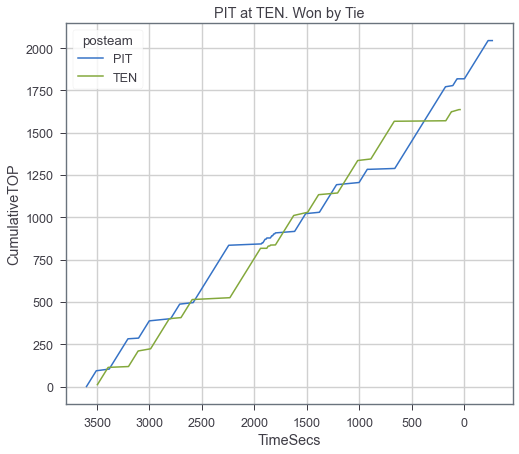

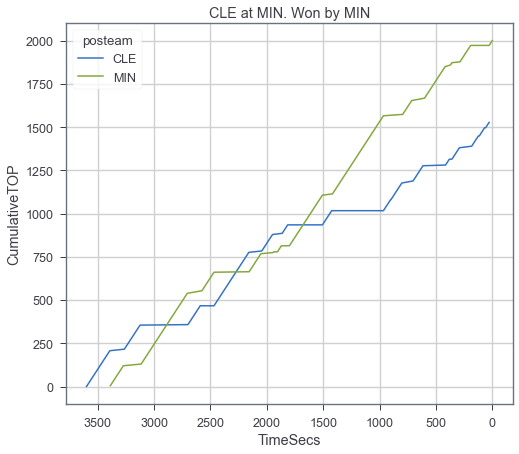

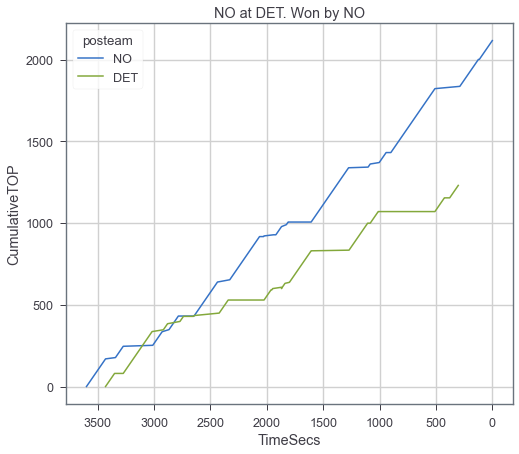

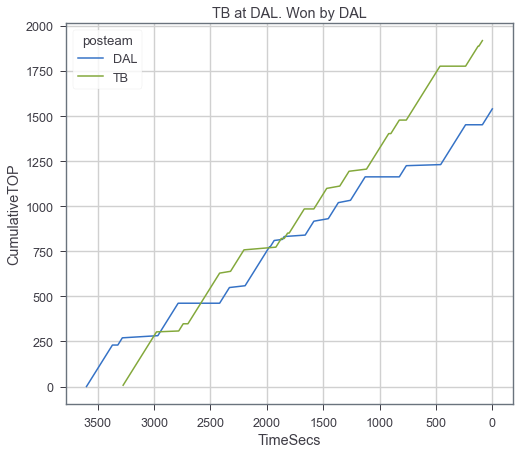

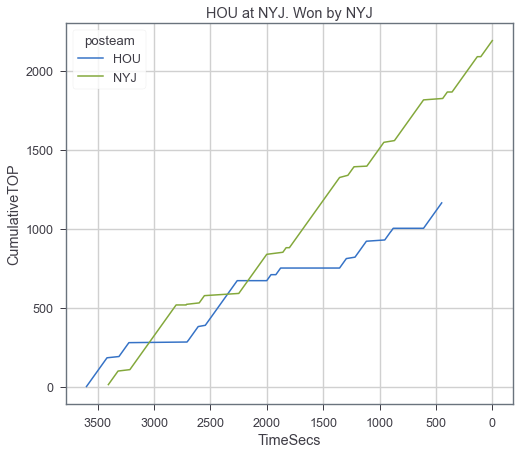

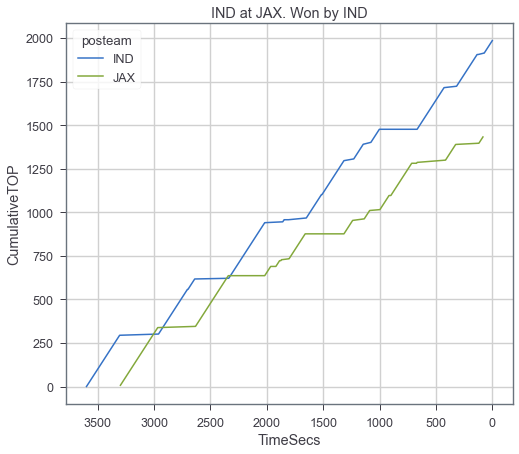

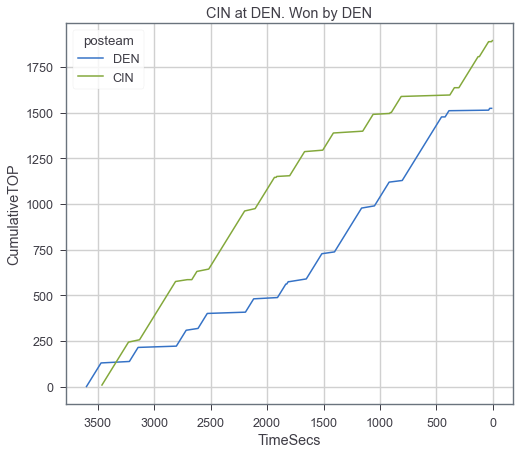

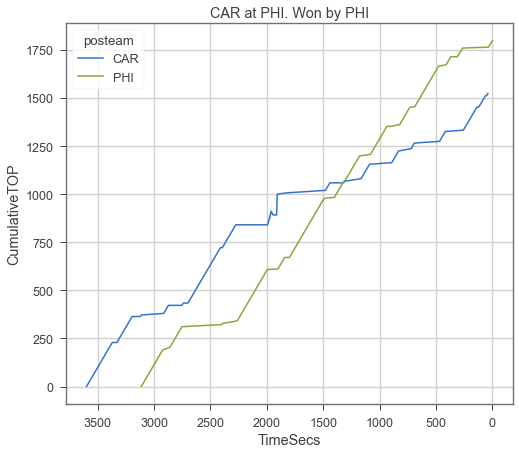

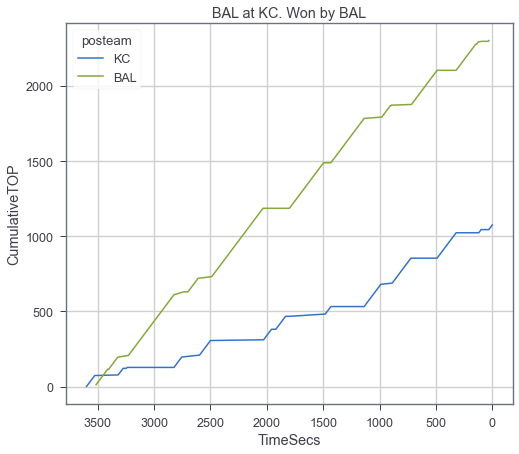

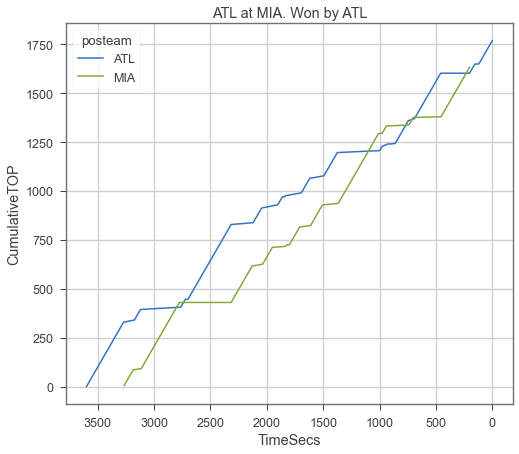

In [13]:
fig = plt.figure()
for game in TimeOfPossessionTracker.GameID.unique()[:10]:
    g = sns.lineplot(
        data=TimeOfPossessionTracker[TimeOfPossessionTracker["GameID"] == game],
        x="TimeSecs",
        y ="CumulativeTOP",
        hue = "posteam"
    )
    winner = NFLWinners.loc[NFLWinners["GameID"] == game, 'WinningTeam'].iloc[0]
    homeTeam = WonGame.loc[WonGame["GameID"] == game, 'HomeTeam'].iloc[0]
    awayTeam = WonGame.loc[WonGame["GameID"] == game, 'AwayTeam'].iloc[0]
    if winner == "Tie":
        winner = "Tie"
    elif winner == "Home":
        winner = homeTeam
    else:
        winner = awayTeam
    g.set(title="{} at {}. Won by {}".format(homeTeam, awayTeam, winner))
    g.invert_xaxis()
    plt.show()


<h1><a name="AnalysisInitial"></a>Initial Analysis</h1>
We see here that in 7/10 games the team that had a greater time of possession won the game. In 2/10 games, the team that had less time of possession won. And in one of the games regulation play ended with the game tied. This seems to indicate that having possession of the ball for longer is correlated with winning the game, which makes sense initially. Teams that are in the lead seem to be more likely to run down the clock in order to decrease the amount of time that the opposing team has to score. But Arkes argued that whole game statistics can not be considered accurate because the second half is endogenic to the first half. So we should take a look at these graphs using only first half statistics. 

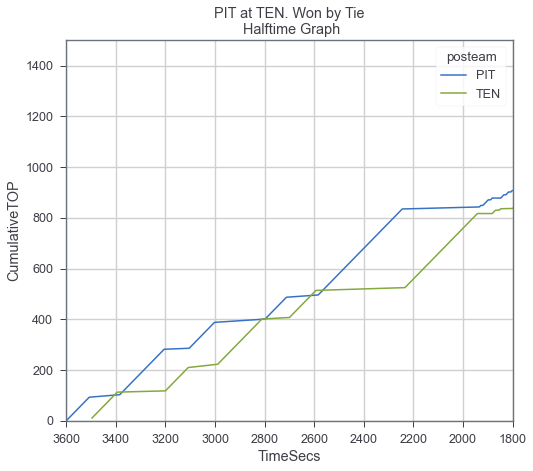

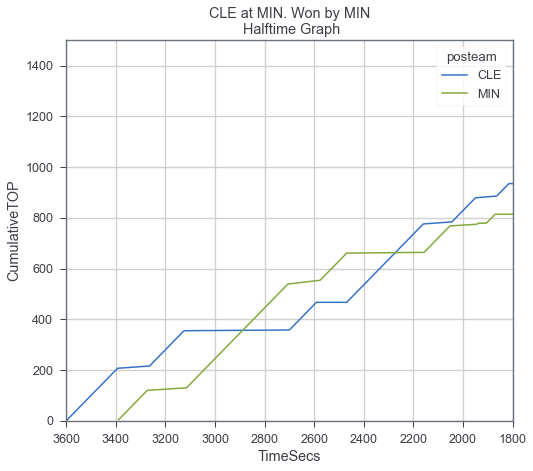

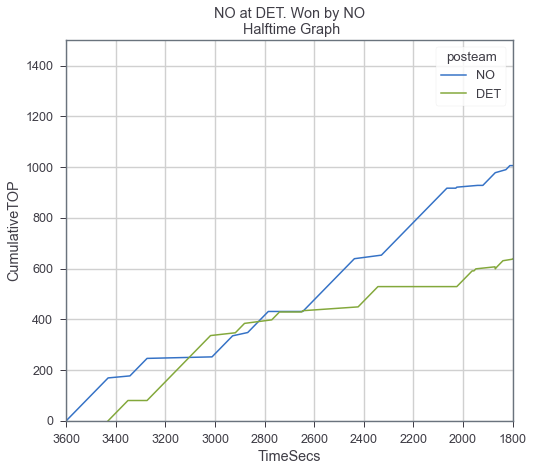

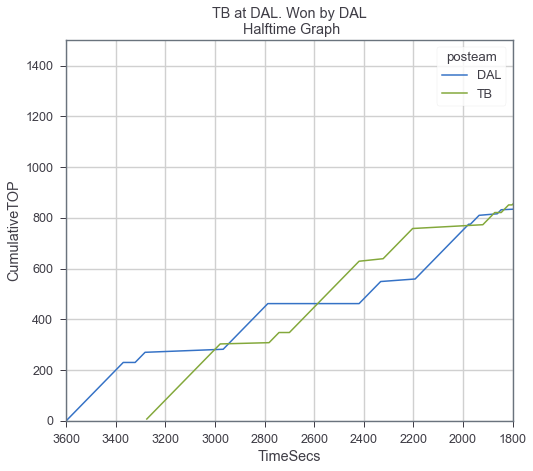

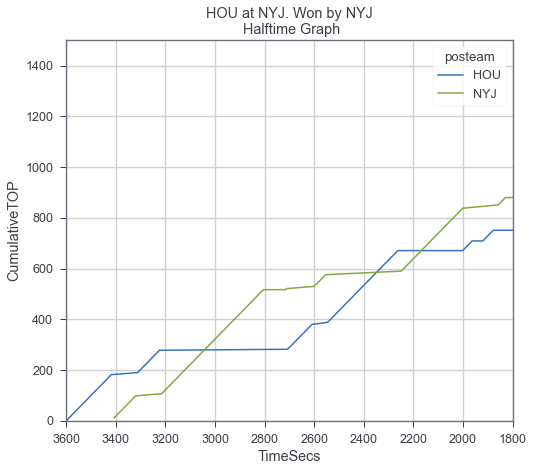

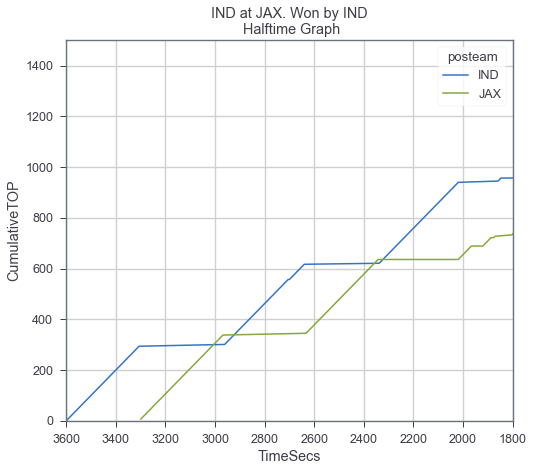

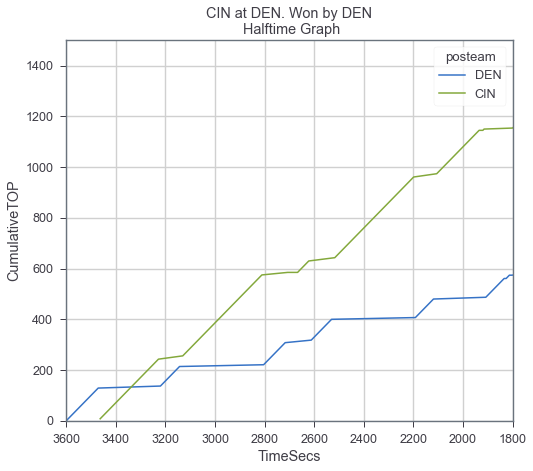

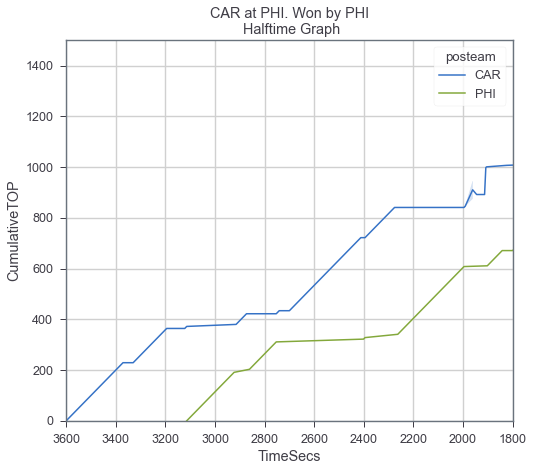

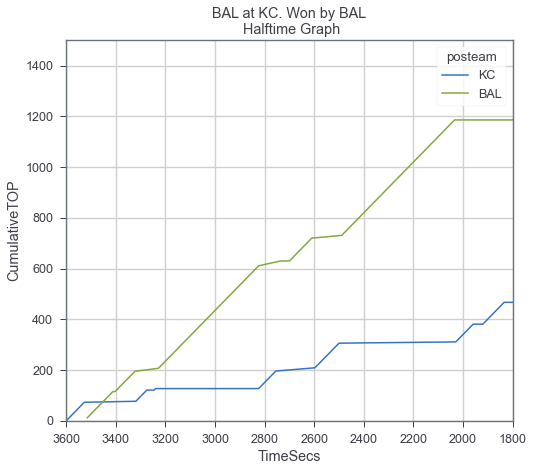

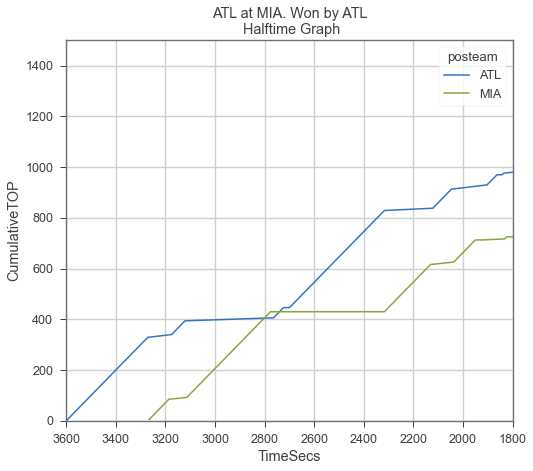

In [14]:
fig = plt.figure()
for game in TimeOfPossessionTracker.GameID.unique()[:10]:
    g = sns.lineplot(
        data=TimeOfPossessionTracker[TimeOfPossessionTracker["GameID"] == game],
        x="TimeSecs",
        y ="CumulativeTOP",
        hue = "posteam"
    )
    winner = NFLWinners.loc[NFLWinners["GameID"] == game, 'WinningTeam'].iloc[0]
    homeTeam = df.loc[df["GameID"] == game, 'HomeTeam'].iloc[0]
    awayTeam = df.loc[df["GameID"] == game, 'AwayTeam'].iloc[0]
    if winner == "Tie":
        winner = "Tie"
    elif winner == "Home":
        winner = homeTeam
    else:
        winner = awayTeam
    g.set(title="{} at {}. Won by {}\n Halftime Graph".format(homeTeam, awayTeam, winner))
    g.set_ylim(0,1500)
    g.set_xlim(3600,1800)
    plt.show()


<h1><a name="HalftimeTOP"></a>Analysis at the Half</h1>
We see here that in 6/10 games the team that had a greater time of possession won the game. In 3/10 games, the team that had less time of possession won. And in one of the games regulation play ended with the game tied. That means that 1/10 games flipped when viewing only the first half, but it flipped in the wrong direction. This seems to indicate that while the first half might affect the second half, at least in terms of Time of Possession, we are better off looking at whole game statistics.

The reason for this might be that teams in the first half are still trying to build up a lead. Since there is a major pause in the game at halftime where the teams get to go to the locker room and talk to their coach, many teams may be trying to push their advantage before that happens. This means that winning teams are not as likely to decelerate gameplay near the end of the second quarter as they are in the second half. 

<h1><a name="Squads"></a>Breaking Down the Offense</h1>
Controlling the clock is considered an important part of the game, but at the end of the day points win football games. So let's take a look at the two parts of an offensive squad, the Passing Team and the Rushing Team.

A Note: While special teams can also score points, most of the time positions such as punt returner and kickoff returner are filled with a player from another squad such as a Running Back, Wide Receiver, or Safety. While there have been cases of return specialists, that is beyond the scope of this investigation although worth looking into as an extension. 

In [15]:
NFLGeneral = NFL2016[["HomeTeam", "AwayTeam", "GameID", "Drive", "qtr", "down", "yrdline100", 
                     "FirstDown", "Yards.Gained", "Touchdown", "PlayType"]]
NFLGeneral.head()

,HomeTeam,AwayTeam,GameID,Drive,qtr,down,yrdline100,FirstDown,Yards.Gained,Touchdown,PlayType
0,PIT,TEN,2009091000,1,1,NaN,30.0,NaN,39,0,Kickoff
1,PIT,TEN,2009091000,1,1,1.0,58.0,0.0,5,0,Pass
2,PIT,TEN,2009091000,1,1,2.0,53.0,0.0,-3,0,Run
3,PIT,TEN,2009091000,1,1,3.0,56.0,0.0,0,0,Pass
4,PIT,TEN,2009091000,1,1,4.0,56.0,1.0,0,0,Punt


In [16]:
NFLPassing = NFL2016[["GameID","Drive", "HomeTeam", "AwayTeam", "posteam", "PlayTimeDiff","TimeSecs", "PassOutcome", "AirYards", "YardsAfterCatch", "Yards.Gained", "PassLocation", 
                      "InterceptionThrown", "QBHit", "Season"]]
NFLPassing = NFLPassing.dropna()
NFLPassing = NFLPassing[NFLPassing.PassOutcome != "Incomplete Pass"]
df = NFLPassing
EachGamePassing = NFLPassing.groupby(["GameID", "posteam"])
for group_key, group_value in TimeOfPossession:
    group = EachGamePassing.get_group(group_key)
    df.loc[group.index, "CumulativePassingYardage"] = group.cumsum()["Yards.Gained"]
NFLPassing = df

<h1><a name="Passing"></a>A Look at the Passing Squad</h1>
We can identify a passing play as one where all of our passing variables exist. This includes things like the PassOutcome and AirYards. So if we isolate those variables and drop the lines with NaN values, we can create a table that only has passing plays. Further, we want to drop passing plays that are incomplete as they are not going to be important for our analysis which focuses on the average yardage of completed passes. 

Incomplete passes would unfairly weight our results down as it would be a gain of 0 yards on an incomplete pass. This is unfair because often an incomplete pass is the result of a QB throwing the ball away to avoid losing yardage to a sack. In plays like this, the incomplete pass may be instead a theoretical gain of 5 yards or more.  

We will create an aditional column that tracks the Cumulative Passing Yardage for the game. 

In [17]:
NFLPassing = df
NFLPassing

,GameID,Drive,HomeTeam,AwayTeam,posteam,PlayTimeDiff,TimeSecs,PassOutcome,AirYards,YardsAfterCatch,Yards.Gained,PassLocation,InterceptionThrown,QBHit,Season,CumulativePassingYardage
1,2009091000,1,PIT,TEN,PIT,7.0,3593.0,Complete,-3,8,5,left,0,0,2009,5.0
6,2009091000,2,PIT,TEN,TEN,36.0,3460.0,Complete,3,1,4,left,0,0,2009,4.0
9,2009091000,3,PIT,TEN,PIT,10.0,3384.0,Complete,-2,5,3,right,0,0,2009,8.0
10,2009091000,3,PIT,TEN,PIT,36.0,3348.0,Complete,-1,11,10,left,0,0,2009,18.0
12,2009091000,3,PIT,TEN,PIT,38.0,3283.0,Complete,-2,11,9,right,0,0,2009,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362428,2017010102,18,DET,GB,DET,4.0,166.0,Complete,9,2,11,right,0,0,2016,277.0
362429,2017010102,18,DET,GB,DET,22.0,144.0,Complete,11,8,19,middle,0,0,2016,296.0
362430,2017010102,18,DET,GB,DET,20.0,124.0,Complete,8,16,24,middle,0,0,2016,320.0
362433,2017010102,18,DET,GB,DET,4.0,113.0,Complete,6,0,6,left,0,0,2016,326.0


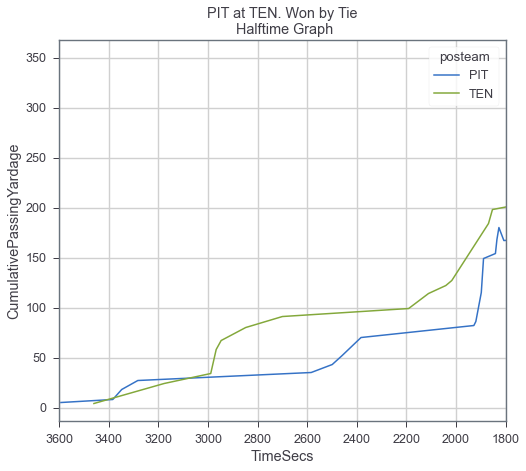

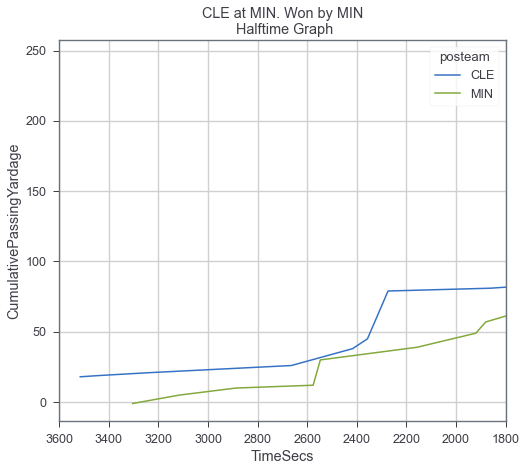

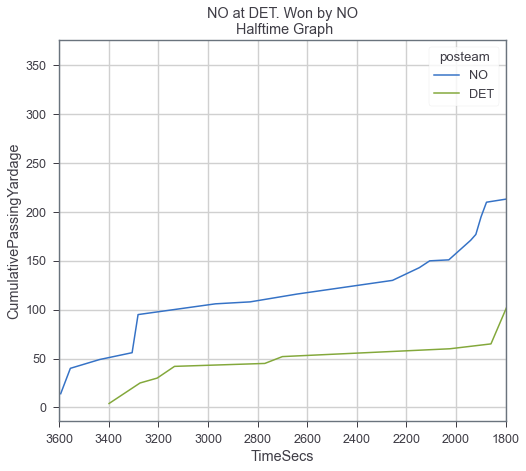

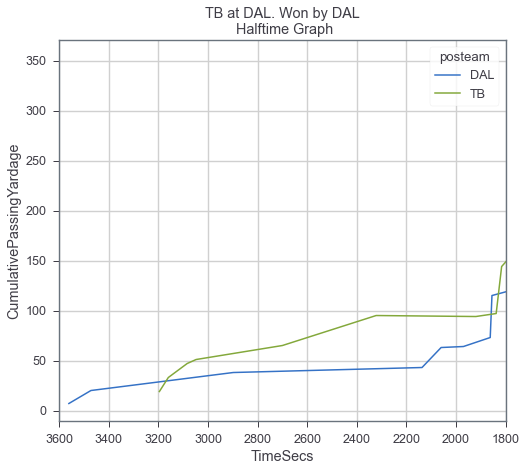

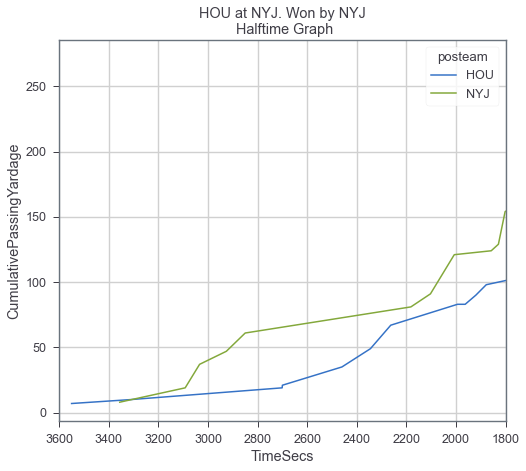

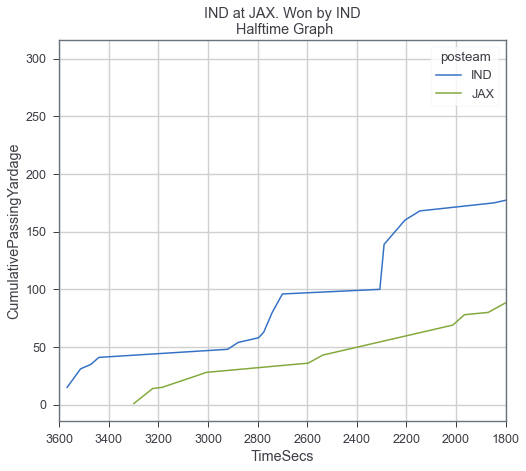

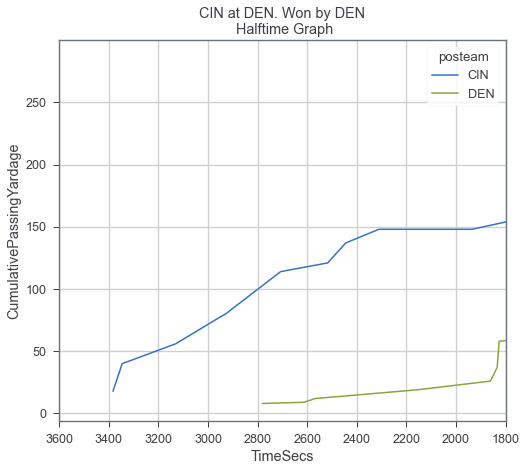

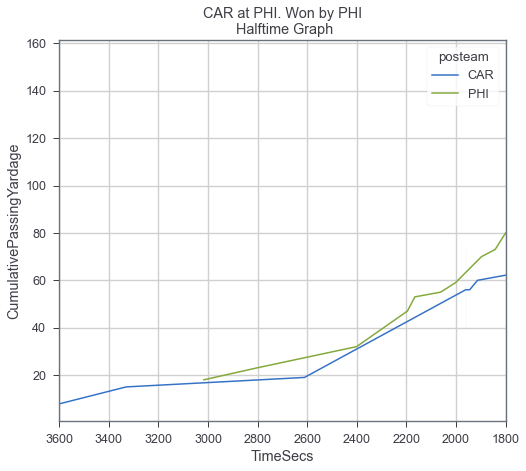

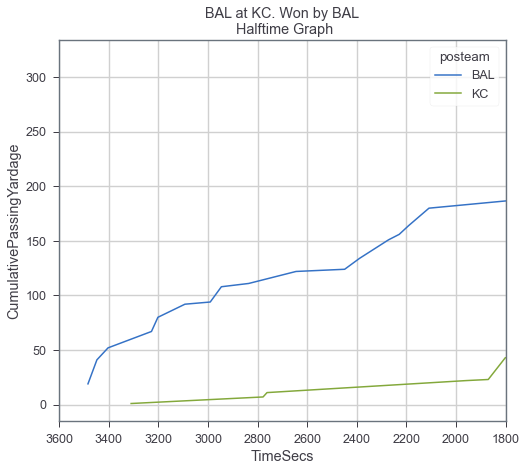

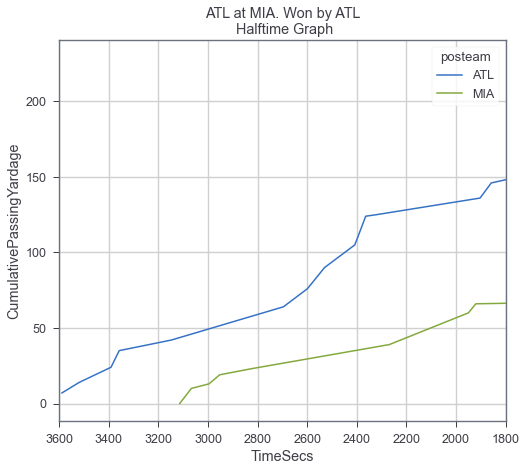

In [18]:
fig = plt.figure()
for game in NFLPassing.GameID.unique()[:10]:
    g = sns.lineplot(
        data=NFLPassing[NFLPassing["GameID"] == game],
        x = "TimeSecs",
        y ="CumulativePassingYardage",
        hue = "posteam"
    )
    winner = NFLWinners.loc[NFLWinners["GameID"] == game, 'WinningTeam'].iloc[0]
    homeTeam = NFLPassing.loc[df["GameID"] == game, 'HomeTeam'].iloc[0]
    awayTeam = NFLPassing.loc[df["GameID"] == game, 'AwayTeam'].iloc[0]
    if winner == "Tie":
        winner = "Tie"
    elif winner == "Home":
        winner = homeTeam
    else:
        winner = awayTeam
    
    g.set_xlim(3600,1800)
    g.set(title="{} at {}. Won by {}\n Halftime Graph".format(homeTeam, awayTeam, winner))
    plt.show()

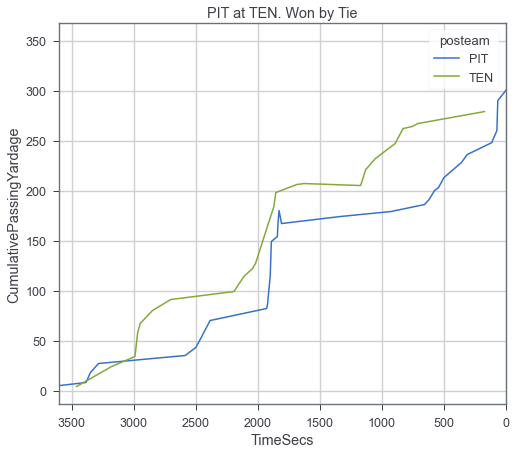

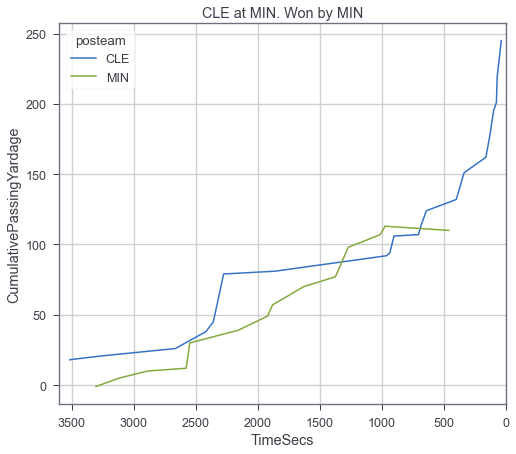

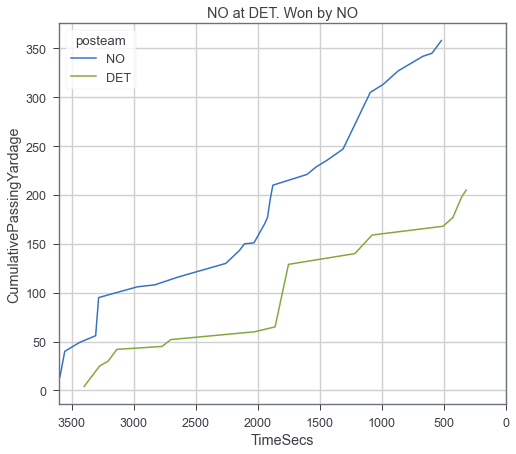

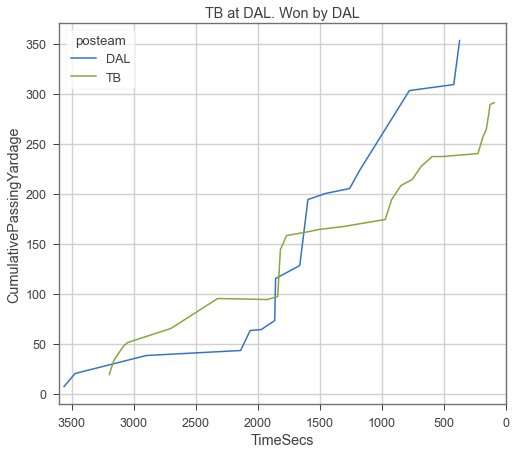

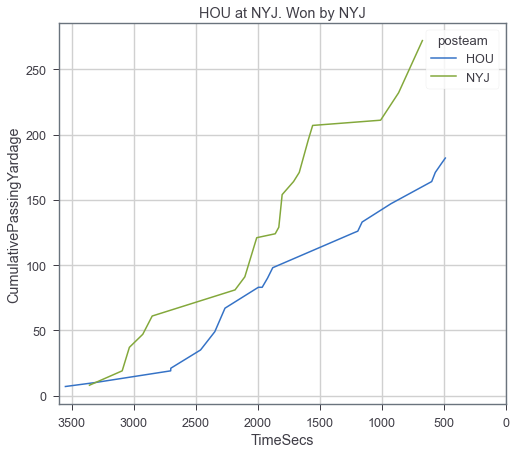

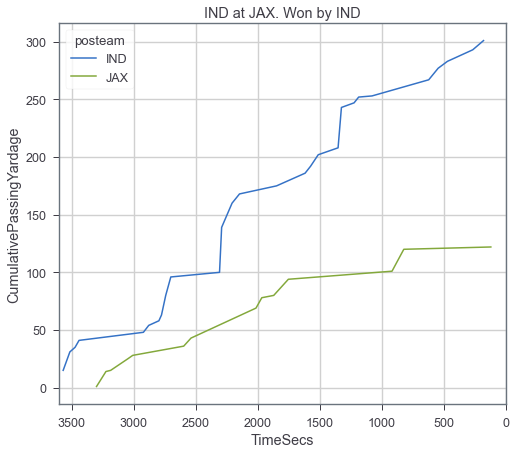

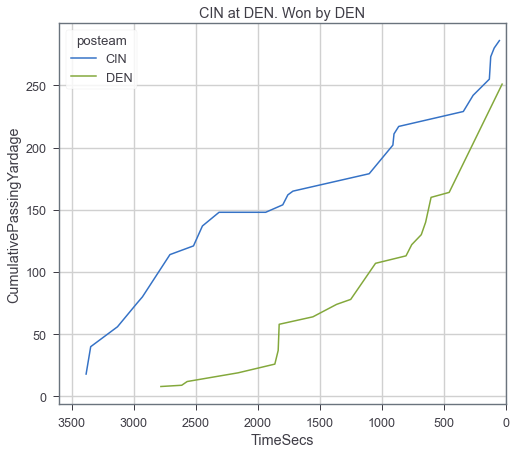

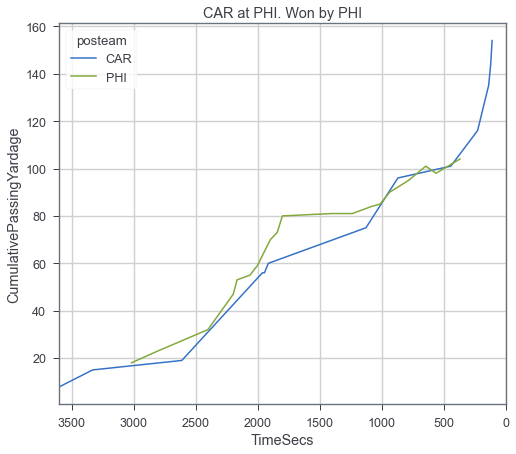

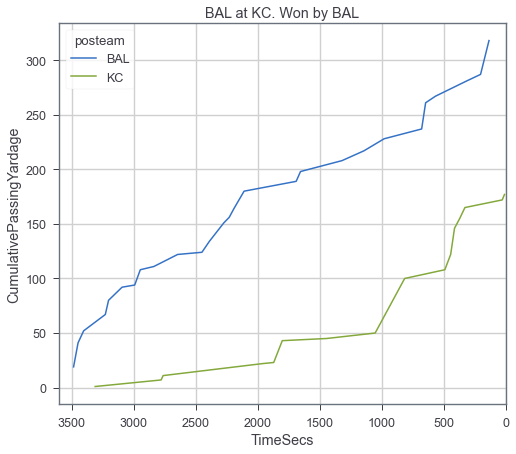

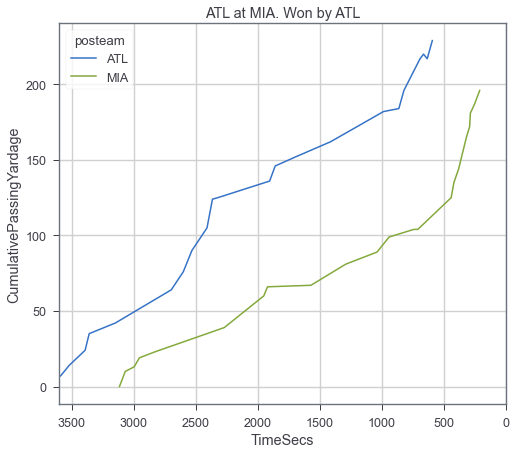

In [19]:
fig = plt.figure()
for game in NFLPassing.GameID.unique()[:10]:
    g = sns.lineplot(
        data=NFLPassing[NFLPassing["GameID"] == game],
        x = "TimeSecs",
        y ="CumulativePassingYardage",
        hue = "posteam"
    )
    winner = NFLWinners.loc[NFLWinners["GameID"] == game, 'WinningTeam'].iloc[0]
    homeTeam = NFLPassing.loc[NFLPassing["GameID"] == game, 'HomeTeam'].iloc[0]
    awayTeam = NFLPassing.loc[NFLPassing["GameID"] == game, 'AwayTeam'].iloc[0]
    if winner == "Tie":
        winner = "Tie"
    elif winner == "Home":
        winner = homeTeam
    else:
        winner = awayTeam
    
    g.set_xlim(3600,0)
    g.set(title="{} at {}. Won by {}".format(homeTeam, awayTeam, winner))
    plt.show()

In [20]:
NFLRushing = NFL2016[["GameID","Drive", "HomeTeam", "AwayTeam", "posteam", "PlayTimeDiff", "TimeSecs", "Rusher","Yards.Gained", "RunLocation", "RunGap", "Season"]]
NFLRushing = NFLRushing.dropna()
df = NFLRushing
EachGameRushing = NFLRushing.groupby(["GameID", "posteam"])
for group_key, group_value in TimeOfPossession:
    group = EachGameRushing.get_group(group_key)
    df.loc[group.index, "CumulativeRushingYardage"] = group.cumsum()["Yards.Gained"]
NFLRushing = df

<h1><a name="Rushing"></a>The Rushing Squad</h1>
We can do similar analysis for the rushing squad except using plays that contain a Rusher. In this case we want to keep track of the Cumulative Rushing Yardage for the game. 

In [21]:
NFLRushing

,GameID,Drive,HomeTeam,AwayTeam,posteam,PlayTimeDiff,TimeSecs,Rusher,Yards.Gained,RunLocation,RunGap,Season,CumulativeRushingYardage
2,2009091000,1,PIT,TEN,PIT,37.0,3556.0,W.Parker,-3,right,end,2009,-3.0
7,2009091000,2,PIT,TEN,TEN,29.0,3431.0,C.Johnson,-2,left,end,2009,-2.0
11,2009091000,3,PIT,TEN,PIT,27.0,3321.0,W.Parker,-1,right,guard,2009,-4.0
15,2009091000,4,PIT,TEN,TEN,5.0,3200.0,C.Johnson,32,right,end,2009,30.0
17,2009091000,4,PIT,TEN,TEN,33.0,3144.0,C.Johnson,3,left,end,2009,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
362396,2017010102,15,DET,GB,GB,27.0,661.0,C.Michael,1,right,tackle,2016,85.0
362401,2017010102,16,DET,GB,DET,6.0,596.0,Z.Zenner,5,right,tackle,2016,50.0
362409,2017010102,17,DET,GB,GB,0.0,462.0,T.Montgomery,7,left,end,2016,92.0
362411,2017010102,17,DET,GB,GB,42.0,376.0,A.Rodgers,13,left,end,2016,105.0


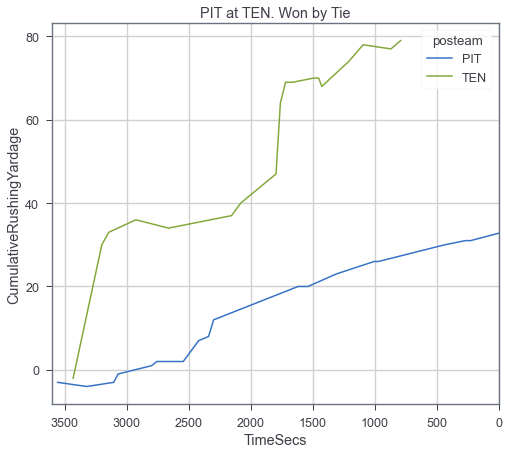

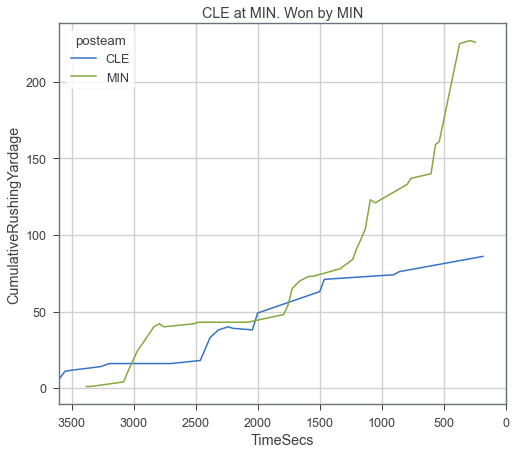

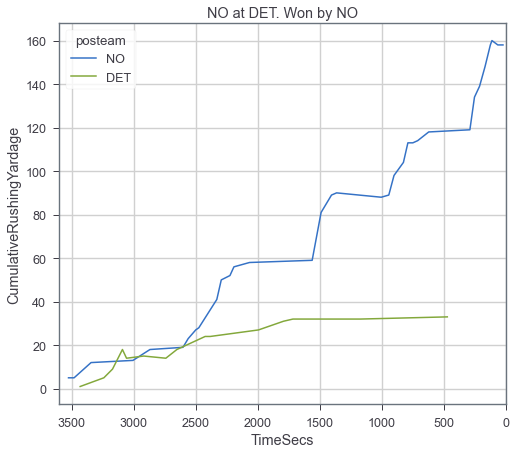

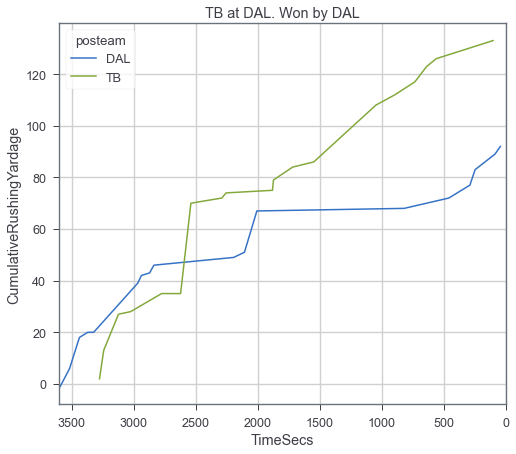

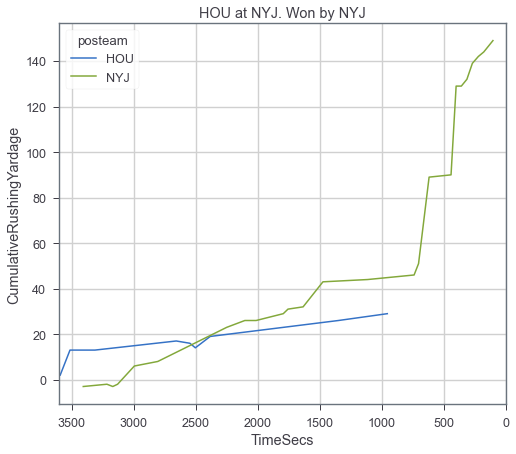

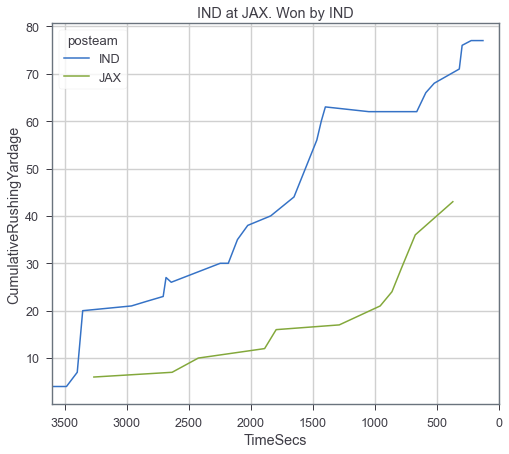

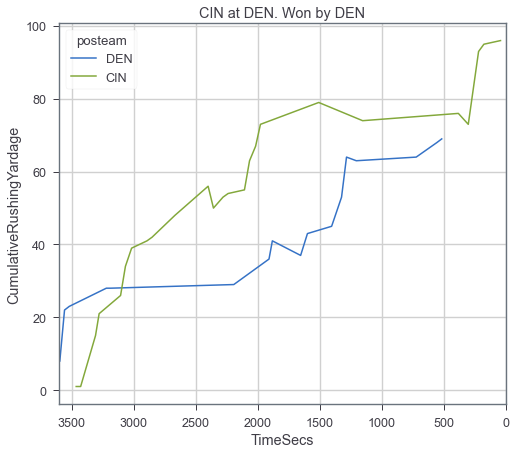

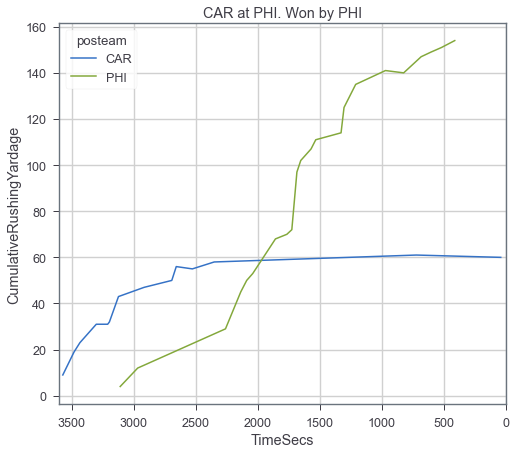

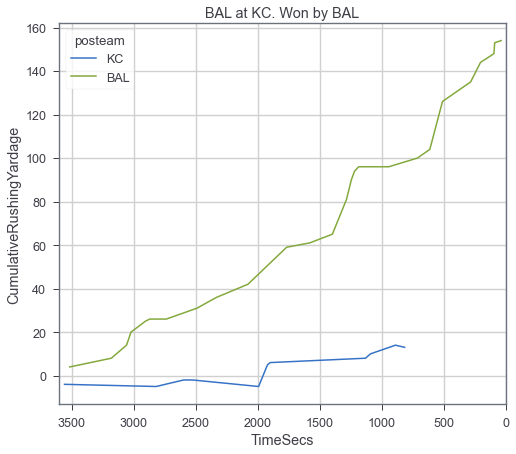

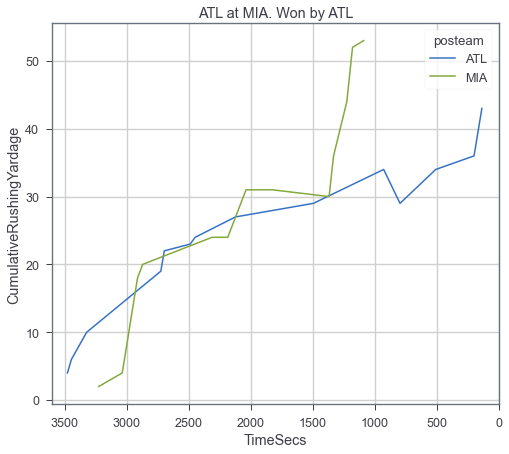

In [22]:
fig = plt.figure()
for game in NFLRushing.GameID.unique()[:10]:
    g = sns.lineplot(
        data=NFLRushing[NFLRushing["GameID"] == game],
        x = "TimeSecs",
        y ="CumulativeRushingYardage",
        hue = "posteam"
    )
    winner = NFLWinners.loc[NFLWinners["GameID"] == game, 'WinningTeam'].iloc[0]
    homeTeam = NFLRushing.loc[NFLRushing["GameID"] == game, 'HomeTeam'].iloc[0]
    awayTeam = NFLRushing.loc[NFLRushing["GameID"] == game, 'AwayTeam'].iloc[0]
    if winner == "Tie":
        winner = "Tie"
    elif winner == "Home":
        winner = homeTeam
    else:
        winner = awayTeam
    g.set_xlim(3600,0)
    g.set(title="{} at {}. Won by {}".format(homeTeam, awayTeam, winner))
    plt.show()

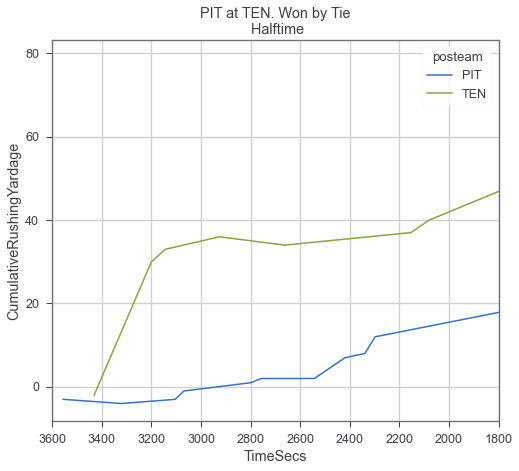

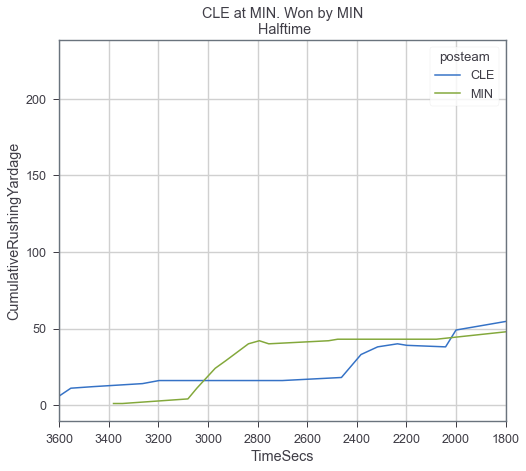

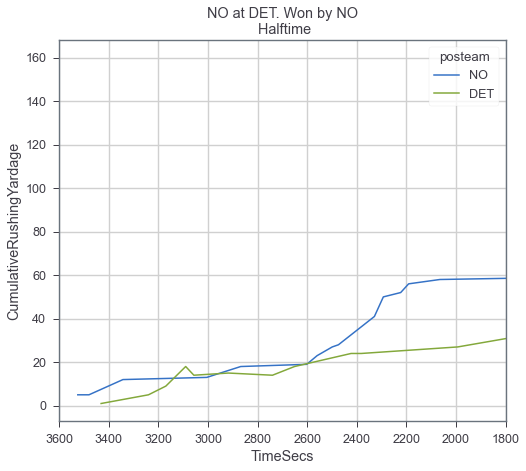

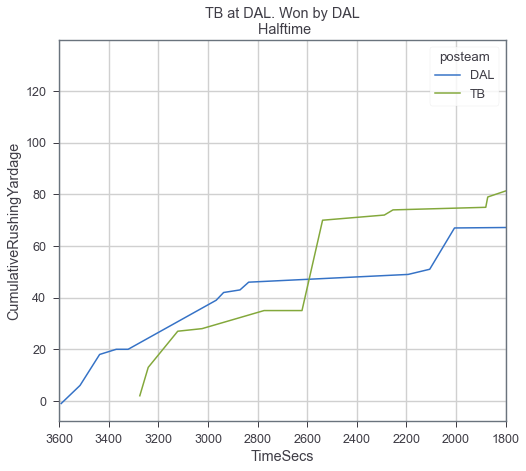

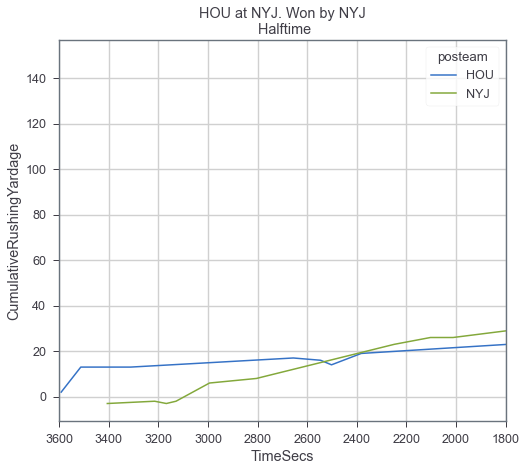

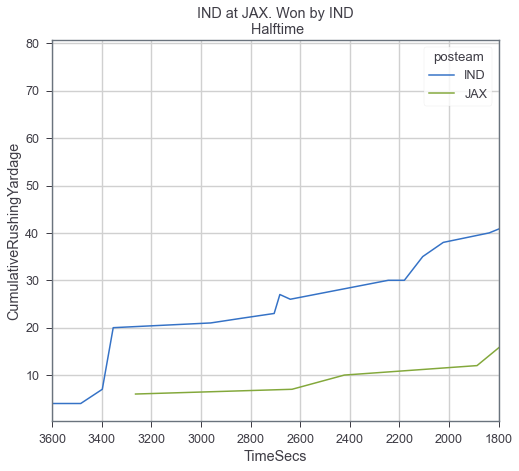

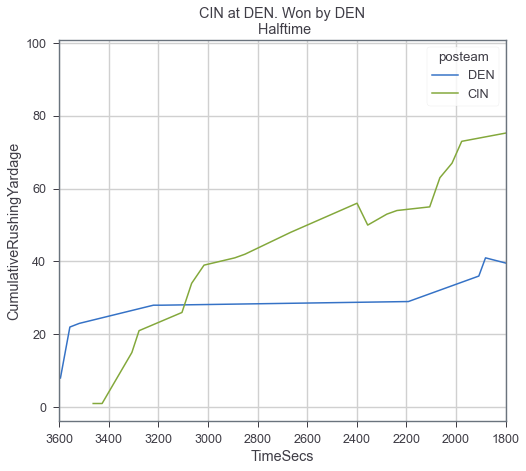

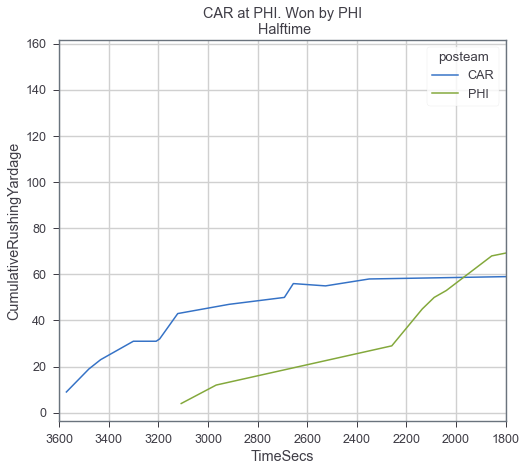

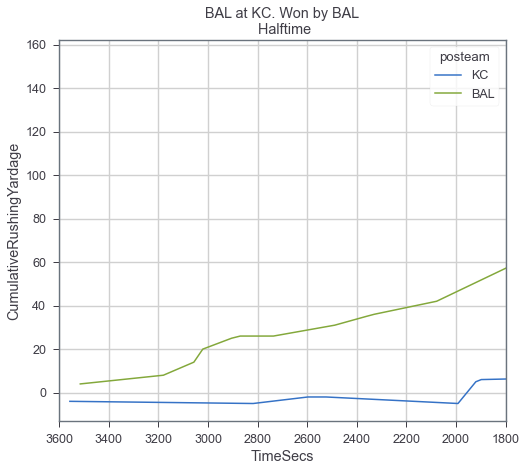

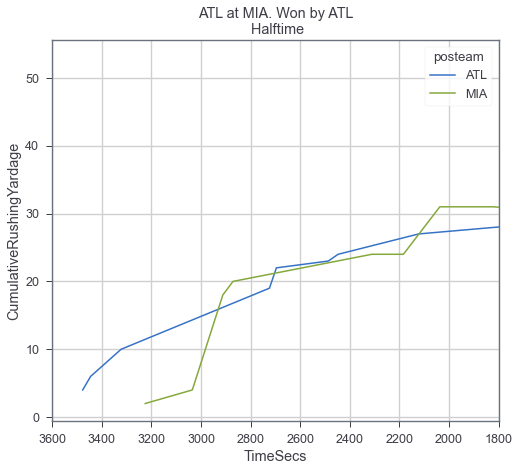

In [23]:
fig = plt.figure()
for game in NFLRushing.GameID.unique()[:10]:
    g = sns.lineplot(
        data=NFLRushing[NFLRushing["GameID"] == game],
        x = "TimeSecs",
        y ="CumulativeRushingYardage",
        hue = "posteam"
    )
    winner = NFLWinners.loc[NFLWinners["GameID"] == game, 'WinningTeam'].iloc[0]
    homeTeam = NFLRushing.loc[NFLRushing["GameID"] == game, 'HomeTeam'].iloc[0]
    awayTeam = NFLRushing.loc[NFLRushing["GameID"] == game, 'AwayTeam'].iloc[0]
    if winner == "Tie":
        winner = "Tie"
    elif winner == "Home":
        winner = homeTeam
    else:
        winner = awayTeam
    g.set_xlim(3600,1800)
    g.set(title="{} at {}. Won by {}\n Halftime".format(homeTeam, awayTeam, winner))
    plt.show()

Let's try to get these together into a subplot so that we can evaluate multiple metrics for one game at a time

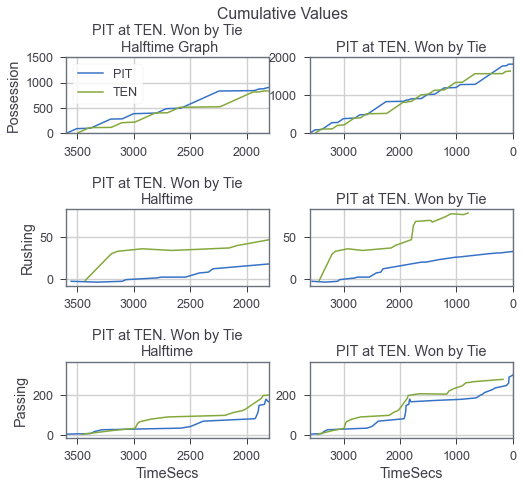

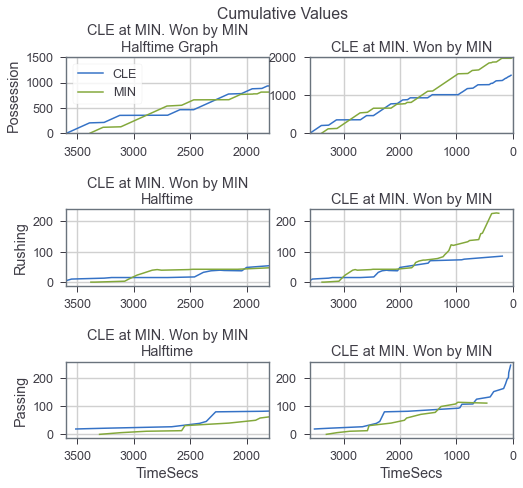

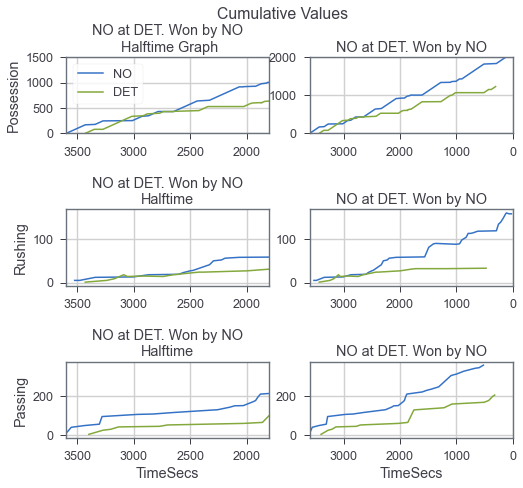

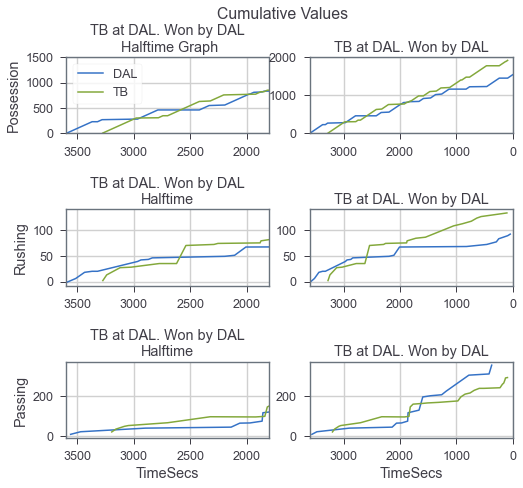

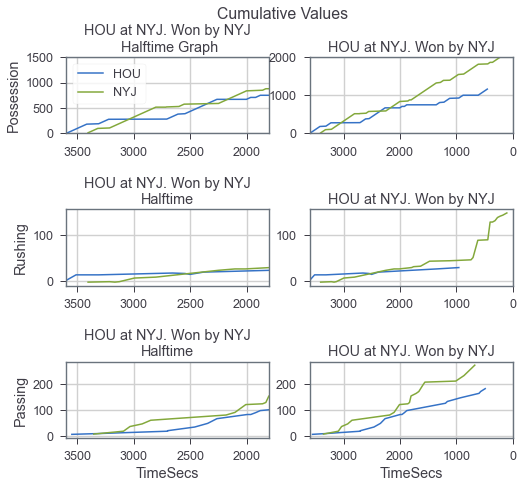

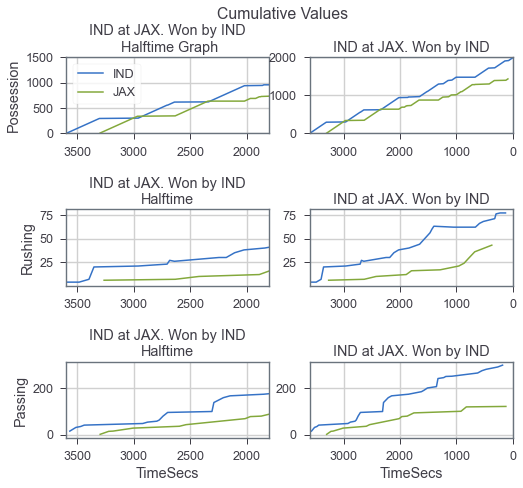

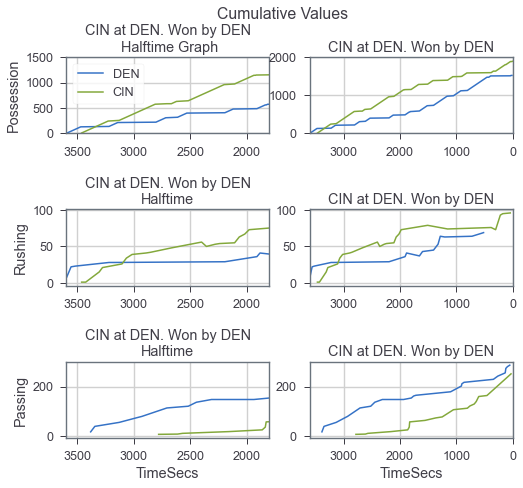

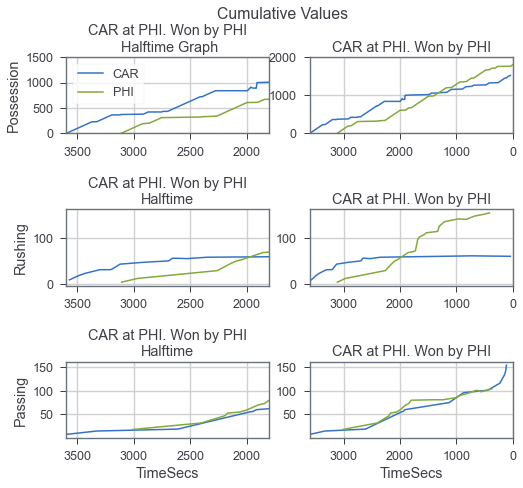

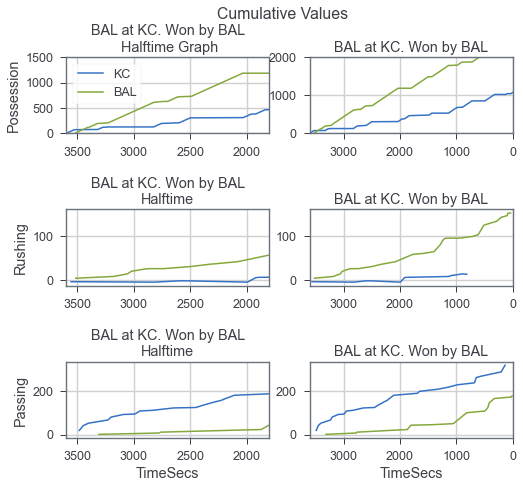

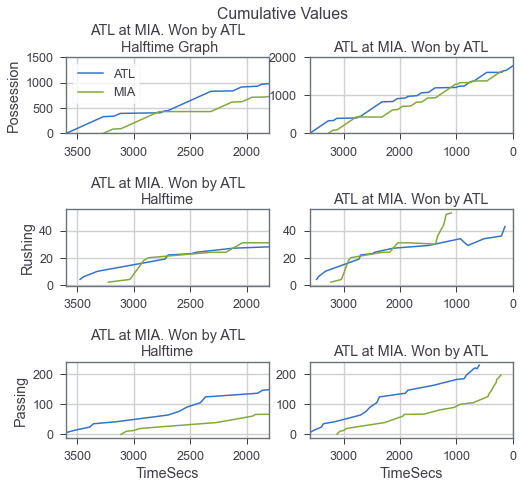

In [24]:

for game in NFLRushing.GameID.unique()[0:10]:
    # Cumulative TOP
    fig = plt.figure()
    fig.suptitle("Cumulative Values")
    plt.subplots_adjust(hspace=1)
    plt.subplot(3,2,1)
    g = sns.lineplot(
        data=TimeOfPossessionTracker[TimeOfPossessionTracker["GameID"] == game],
        x="TimeSecs",
        y ="CumulativeTOP",
        hue = "posteam"
    )
    winner = NFLWinners.loc[NFLWinners["GameID"] == game, 'WinningTeam'].iloc[0]
    homeTeam = WonGame.loc[WonGame["GameID"] == game, 'HomeTeam'].iloc[0]
    awayTeam = WonGame.loc[WonGame["GameID"] == game, 'AwayTeam'].iloc[0]
    if winner == "Tie":
        winner = "Tie"
    elif winner == "Home":
        winner = homeTeam
    else:
        winner = awayTeam
    g.set(title="{} at {}. Won by {}\n Halftime Graph".format(homeTeam, awayTeam, winner))
    g.set_ylim(0,1500)
    g.set_xlim(3600,1800)
    g.set(xlabel = None, ylabel="Possession")
    g.legend(loc='best')
    plt.subplot(3,2,2)
    g = sns.lineplot(
        data=TimeOfPossessionTracker[TimeOfPossessionTracker["GameID"] == game],
        x="TimeSecs",
        y ="CumulativeTOP",
        hue = "posteam"
    )
    g.set(title="{} at {}. Won by {}".format(homeTeam, awayTeam, winner))
    g.set_ylim(0,2000)
    g.set_xlim(3600,0)
    g.set(xlabel = None, ylabel = None)
    g.get_legend().remove()
    
    # Cumulative Rushing
    plt.subplot(3,2,3)
    g = sns.lineplot(
        data=NFLRushing[NFLRushing["GameID"] == game],
        x = "TimeSecs",
        y ="CumulativeRushingYardage",
        hue = "posteam"
    )
    winner = NFLWinners.loc[NFLWinners["GameID"] == game, 'WinningTeam'].iloc[0]
    homeTeam = NFLRushing.loc[NFLRushing["GameID"] == game, 'HomeTeam'].iloc[0]
    awayTeam = NFLRushing.loc[NFLRushing["GameID"] == game, 'AwayTeam'].iloc[0]
    if winner == "Tie":
        winner = "Tie"
    elif winner == "Home":
        winner = homeTeam
    else:
        winner = awayTeam
    g.set_xlim(3600,1800)
    g.set(xlabel = None, ylabel="Rushing")
    g.set(title="{} at {}. Won by {}\nHalftime".format(homeTeam, awayTeam, winner))
    g.get_legend().remove()
    plt.subplot(3,2,4)
    g = sns.lineplot(
        data=NFLRushing[NFLRushing["GameID"] == game],
        x = "TimeSecs",
        y ="CumulativeRushingYardage",
        hue = "posteam"
    )
    g.set_xlim(3600,0)
    g.set(xlabel = None, ylabel = None)
    g.set(title="{} at {}. Won by {}".format(homeTeam, awayTeam, winner))
    g.get_legend().remove()
    
    plt.subplot(3,2,5)
    g = sns.lineplot(
        data=NFLPassing[NFLPassing["GameID"] == game],
        x = "TimeSecs",
        y ="CumulativePassingYardage",
        hue = "posteam"
    )
    winner = NFLWinners.loc[NFLWinners["GameID"] == game, 'WinningTeam'].iloc[0]
    homeTeam = NFLPassing.loc[NFLPassing["GameID"] == game, 'HomeTeam'].iloc[0]
    awayTeam = NFLPassing.loc[NFLPassing["GameID"] == game, 'AwayTeam'].iloc[0]
    if winner == "Tie":
        winner = "Tie"
    elif winner == "Home":
        winner = homeTeam
    else:
        winner = awayTeam
    
    g.set_xlim(3600,1800)
    g.set(title="{} at {}. Won by {}\nHalftime".format(homeTeam, awayTeam, winner))
    g.set(ylabel = "Passing")
    g.get_legend().remove()
    plt.subplot(3,2,6)
    g = sns.lineplot(
        data=NFLPassing[NFLPassing["GameID"] == game],
        x = "TimeSecs",
        y ="CumulativePassingYardage",
        hue = "posteam"
    )
    g.set_xlim(3600,0)
    g.set(ylabel = None)
    g.set(title="{} at {}. Won by {}".format(homeTeam, awayTeam, winner))
    g.get_legend().remove()

<h1><a name="TimeToCondense"></a>Condensing this Data</h1>
These graphs are great for looking at a few games at a time, maybe even 50, but we have nearly 2000 games to analyze. For that, we really want to consider averages across games and want our data condensed even further. To do that we are going to need to split our data into separate tables for Winners and Losers (which we can do since we added a feature that identifies this) and add a few more features. Notably, we want to take the features that we have added so far and condense them into per drive statistics. Then, for each game, we need to average those out and get those all into a table. 

In [25]:
# We should drop our games that ended in a tie because they aren't useful for analysis
NFLWinners = NFLWinners[NFLWinners["WinningTeam"] != "Tie"]
NFLLosers = NFLLosers[NFLLosers["LosingTeam"] != "Tie"]

In [26]:
NFLLosers

,GameID,LosingTeam
1,2009091300,Away
2,2009091301,Away
3,2009091302,Home
4,2009091303,Home
5,2009091304,Home
...,...,...
2043,2017010111,Home
2044,2017010112,Away
2045,2017010113,Home
2046,2017010114,Home


In [27]:
lastDriveArray = []
for game in NFLWinners.GameID:
    lastDriveFirstHalf = NFL2016[(NFL2016["GameID"] == game) & (NFL2016["TimeSecs"] > 1800)].iloc[-1]["Drive"]
    lastDriveArray.append(lastDriveFirstHalf)
NFLWinners["lastDriveFirstHalf"] = lastDriveArray
NFLLosers["lastDriveFirstHalf"] = lastDriveArray

In [28]:
# Ok, now for each of these we should get the halftime and final game stats for the teams. Let's 
# always get it in terms of home team
RushingYardsPerDriveWhole = []
RushingYardsPerDriveHalf = []
PassingYardsPerDriveWhole = []
PassingYardsPerDriveHalf = []
PassingTimePerDriveWhole = []
PassingTimePerDriveHalf = []
RushingTimePerDriveWhole = []
RushingTimePerDriveHalf = []

RushingPlaysWhole = []
RushingPlaysHalf = []
PassingPlaysWhole = []
PassingPlaysHalf = []

for game in NFLWinners.GameID:
    winningTeam = NFLWinners.loc[NFLWinners["GameID"] == game]["WinningTeam"].values[0]
    lastDriveFirstHalf = NFLWinners.loc[NFLWinners["GameID"] == game]["lastDriveFirstHalf"].values[0]
    winningTeam = winningTeam + "Team"
    #Rushing Stats
    RushingGroup = NFLRushing[(NFLRushing["GameID"] ==  game) & (NFLRushing["posteam"] == NFLRushing[winningTeam])].groupby(["GameID","Drive"])["Yards.Gained"].sum()
    RushingGroupHalf = NFLRushing[(NFLRushing["GameID"] ==  game) & (NFLRushing["posteam"] == NFLRushing[winningTeam]) & (NFLRushing["Drive"] < lastDriveFirstHalf)].groupby(["GameID","Drive"])["Yards.Gained"].sum()
    RushingTimeGroup = NFLRushing[(NFLRushing["GameID"] ==  game) & (NFLRushing["posteam"] == NFLRushing[winningTeam])].groupby(["GameID","Drive"])["PlayTimeDiff"].sum()
    RushingTimeGroupHalf = NFLRushing[(NFLRushing["GameID"] ==  game) & (NFLRushing["posteam"] == NFLRushing[winningTeam]) & (NFLRushing["Drive"] < lastDriveFirstHalf)].groupby(["GameID","Drive"])["PlayTimeDiff"].sum()

    #Passing Stats
    PassingGroup = NFLPassing[(NFLPassing["GameID"] ==  game) & (NFLPassing["posteam"] == NFLPassing[winningTeam])].groupby(["GameID","Drive"])["Yards.Gained"].sum()
    PassingGroupHalf = NFLPassing[(NFLPassing["GameID"] ==  game) & (NFLPassing["posteam"] == NFLPassing[winningTeam]) & (NFLPassing["Drive"] < lastDriveFirstHalf)].groupby(["GameID","Drive"])["Yards.Gained"].sum()
    PassingTimeGroup = NFLPassing[(NFLPassing["GameID"] ==  game) & (NFLPassing["posteam"] == NFLPassing[winningTeam])].groupby(["GameID","Drive"])["PlayTimeDiff"].sum()
    PassingTimeGroupHalf = NFLPassing[(NFLPassing["GameID"] ==  game) & (NFLPassing["posteam"] == NFLPassing[winningTeam]) & (NFLPassing["Drive"] < lastDriveFirstHalf)].groupby(["GameID","Drive"])["PlayTimeDiff"].sum()

    
    RushingPlaysWhole.append(len(RushingGroup))
    RushingPlaysHalf.append(len(RushingGroupHalf))
    PassingPlaysWhole.append(len(PassingGroup))
    PassingPlaysHalf.append(len(PassingGroupHalf))
    if len(RushingGroup) == 0:
        RushingYardsPerDriveWhole.append(0)
        RushingTimePerDriveWhole.append(0)
    else:
        RushingYardsPerDriveWhole.append(RushingGroup.values.sum() / len(RushingGroup))
        RushingTimePerDriveWhole.append(RushingTimeGroup.values.sum() / len(RushingGroup))
    if len(RushingGroupHalf) == 0:
        RushingYardsPerDriveHalf.append(0)
        RushingTimePerDriveHalf.append(0)
    else:
        RushingYardsPerDriveHalf.append(RushingGroupHalf.values.sum() / len(RushingGroupHalf))
        RushingTimePerDriveHalf.append(RushingTimeGroupHalf.values.sum() / len(RushingGroup))
    if len(PassingGroup) == 0:
        PassingYardsPerDriveWhole.append(0)
        PassingTimePerDriveWhole.append(0)
    else:
        PassingYardsPerDriveWhole.append(PassingGroup.values.sum() / len(PassingGroup))
        PassingTimePerDriveWhole.append(PassingTimeGroup.values.sum() / len(PassingGroup))
    if len(PassingGroupHalf) == 0:
        PassingYardsPerDriveHalf.append(0)
        PassingTimePerDriveHalf.append(0)
    else:
        PassingYardsPerDriveHalf.append(PassingGroupHalf.values.sum() / len(PassingGroupHalf))
        PassingTimePerDriveHalf.append(PassingTimeGroupHalf.values.sum() / len(PassingGroup))

NFLWinners["RushingPlaysWhole"] = RushingPlaysWhole
NFLWinners["RushingYardsPerDriveWhole"] = RushingYardsPerDriveWhole
NFLWinners["RushingPlaysHalf"] = RushingPlaysHalf
NFLWinners["RushingYardsPerDriveHalf"] = RushingYardsPerDriveHalf
NFLWinners["PassingPlaysWhole"] = PassingPlaysWhole
NFLWinners["PassingYardsPerDriveWhole"] = PassingYardsPerDriveWhole
NFLWinners["PassingPlaysHalf"] = PassingPlaysHalf
NFLWinners["PassingYardsPerDriveHalf"] = PassingYardsPerDriveHalf
NFLWinners["PassingTimePerDriveWhole"] = PassingTimePerDriveWhole
NFLWinners["PassingTimePerDriveHalf"] = PassingTimePerDriveHalf
NFLWinners["RushingTimePerDriveWhole"] = RushingTimePerDriveWhole
NFLWinners["RushingTimePerDriveHalf"] = RushingTimePerDriveHalf

Now let's do the same thing for losers

In [29]:
RushingYardsPerDriveWhole = []
RushingYardsPerDriveHalf = []
PassingYardsPerDriveWhole = []
PassingYardsPerDriveHalf = []
PassingTimePerDriveWhole = []
PassingTimePerDriveHalf = []
RushingTimePerDriveWhole = []
RushingTimePerDriveHalf = []

RushingPlaysWhole = []
RushingPlaysHalf = []
PassingPlaysWhole = []
PassingPlaysHalf = []

for game in NFLLosers.GameID:
    losingTeam = NFLLosers.loc[NFLLosers["GameID"] == game]["LosingTeam"].values[0]
    lastDriveFirstHalf = NFLLosers.loc[NFLLosers["GameID"] == game]["lastDriveFirstHalf"].values[0]
    losingTeam = losingTeam + "Team"
    #Rushing Stats
    RushingGroup = NFLRushing[(NFLRushing["GameID"] ==  game) & (NFLRushing["posteam"] == NFLRushing[losingTeam])].groupby(["GameID","Drive"])["Yards.Gained"].sum()
    RushingGroupHalf = NFLRushing[(NFLRushing["GameID"] ==  game) & (NFLRushing["posteam"] == NFLRushing[losingTeam]) & (NFLRushing["Drive"] < lastDriveFirstHalf)].groupby(["GameID","Drive"])["Yards.Gained"].sum()
    RushingTimeGroup = NFLRushing[(NFLRushing["GameID"] ==  game) & (NFLRushing["posteam"] == NFLRushing[losingTeam])].groupby(["GameID","Drive"])["PlayTimeDiff"].sum()
    RushingTimeGroupHalf = NFLRushing[(NFLRushing["GameID"] ==  game) & (NFLRushing["posteam"] == NFLRushing[losingTeam]) & (NFLRushing["Drive"] < lastDriveFirstHalf)].groupby(["GameID","Drive"])["PlayTimeDiff"].sum()

    #Passing Stats
    PassingGroup = NFLPassing[(NFLPassing["GameID"] ==  game) & (NFLPassing["posteam"] == NFLPassing[losingTeam])].groupby(["GameID","Drive"])["Yards.Gained"].sum()
    PassingGroupHalf = NFLPassing[(NFLPassing["GameID"] ==  game) & (NFLPassing["posteam"] == NFLPassing[losingTeam]) & (NFLPassing["Drive"] < lastDriveFirstHalf)].groupby(["GameID","Drive"])["Yards.Gained"].sum()
    PassingTimeGroup = NFLPassing[(NFLPassing["GameID"] ==  game) & (NFLPassing["posteam"] == NFLPassing[losingTeam])].groupby(["GameID","Drive"])["PlayTimeDiff"].sum()
    PassingTimeGroupHalf = NFLPassing[(NFLPassing["GameID"] ==  game) & (NFLPassing["posteam"] == NFLPassing[losingTeam]) & (NFLPassing["Drive"] < lastDriveFirstHalf)].groupby(["GameID","Drive"])["PlayTimeDiff"].sum()

    
    RushingPlaysWhole.append(len(RushingGroup))
    RushingPlaysHalf.append(len(RushingGroupHalf))
    PassingPlaysWhole.append(len(PassingGroup))
    PassingPlaysHalf.append(len(PassingGroupHalf))
    if len(RushingGroup) == 0:
        RushingYardsPerDriveWhole.append(0)
        RushingTimePerDriveWhole.append(0)
    else:
        RushingYardsPerDriveWhole.append(RushingGroup.values.sum() / len(RushingGroup))
        RushingTimePerDriveWhole.append(RushingTimeGroup.values.sum() / len(RushingGroup))
    if len(RushingGroupHalf) == 0:
        RushingYardsPerDriveHalf.append(0)
        RushingTimePerDriveHalf.append(0)
    else:
        RushingYardsPerDriveHalf.append(RushingGroupHalf.values.sum() / len(RushingGroupHalf))
        RushingTimePerDriveHalf.append(RushingTimeGroupHalf.values.sum() / len(RushingGroup))
    if len(PassingGroup) == 0:
        PassingYardsPerDriveWhole.append(0)
        PassingTimePerDriveWhole.append(0)
    else:
        PassingYardsPerDriveWhole.append(PassingGroup.values.sum() / len(PassingGroup))
        PassingTimePerDriveWhole.append(PassingTimeGroup.values.sum() / len(PassingGroup))
    if len(PassingGroupHalf) == 0:
        PassingYardsPerDriveHalf.append(0)
        PassingTimePerDriveHalf.append(0)
    else:
        PassingYardsPerDriveHalf.append(PassingGroupHalf.values.sum() / len(PassingGroupHalf))
        PassingTimePerDriveHalf.append(PassingTimeGroupHalf.values.sum() / len(PassingGroup))

NFLLosers["RushingPlaysWhole"] = RushingPlaysWhole
NFLLosers["RushingYardsPerDriveWhole"] = RushingYardsPerDriveWhole
NFLLosers["RushingPlaysHalf"] = RushingPlaysHalf
NFLLosers["RushingYardsPerDriveHalf"] = RushingYardsPerDriveHalf
NFLLosers["PassingPlaysWhole"] = PassingPlaysWhole
NFLLosers["PassingYardsPerDriveWhole"] = PassingYardsPerDriveWhole
NFLLosers["PassingPlaysHalf"] = PassingPlaysHalf
NFLLosers["PassingYardsPerDriveHalf"] = PassingYardsPerDriveHalf
NFLLosers["PassingTimePerDriveWhole"] = PassingTimePerDriveWhole
NFLLosers["PassingTimePerDriveHalf"] = PassingTimePerDriveHalf
NFLLosers["RushingTimePerDriveWhole"] = RushingTimePerDriveWhole
NFLLosers["RushingTimePerDriveHalf"] = RushingTimePerDriveHalf

In [40]:
NFLWinners

,GameID,WinningTeam,lastDriveFirstHalf,RushingPlaysWhole,RushingYardsPerDriveWhole,RushingPlaysHalf,RushingYardsPerDriveHalf,PassingPlaysWhole,PassingYardsPerDriveWhole,PassingPlaysHalf,PassingYardsPerDriveHalf,PassingTimePerDriveWhole,PassingTimePerDriveHalf,RushingTimePerDriveWhole,RushingTimePerDriveHalf
1,2009091300,Home,10,7,6.142857,3,9.000000,9,25.444444,4,36.500000,64.333333,41.111111,48.428571,35.142857
2,2009091301,Home,10,11,14.000000,5,8.400000,10,31.800000,5,36.000000,58.300000,34.100000,62.090909,27.454545
3,2009091302,Away,13,10,15.400000,3,22.666667,12,8.666667,5,14.600000,34.333333,14.750000,53.400000,9.900000
4,2009091303,Away,11,7,9.857143,3,9.666667,9,27.888889,3,6.333333,43.555556,8.555556,59.714286,18.714286
5,2009091304,Away,12,10,22.600000,4,10.750000,9,12.222222,6,9.500000,38.888889,15.555556,105.500000,47.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2017010111,Away,11,10,12.800000,4,17.500000,7,28.000000,4,32.000000,64.857143,38.285714,65.800000,40.100000
2044,2017010112,Home,11,11,8.818182,5,15.800000,9,24.111111,5,30.400000,43.333333,29.111111,48.545455,20.909091
2045,2017010113,Away,15,11,7.090909,7,5.857143,10,26.800000,4,32.000000,52.700000,33.100000,31.636364,10.545455
2046,2017010114,Away,8,8,7.375000,3,5.333333,7,37.714286,3,44.333333,76.428571,29.571429,68.875000,18.250000


In [41]:
NFLLosers

,GameID,LosingTeam,lastDriveFirstHalf,RushingPlaysWhole,RushingYardsPerDriveWhole,RushingPlaysHalf,RushingYardsPerDriveHalf,PassingPlaysWhole,PassingYardsPerDriveWhole,PassingPlaysHalf,PassingYardsPerDriveHalf,PassingTimePerDriveWhole,PassingTimePerDriveHalf,RushingTimePerDriveWhole,RushingTimePerDriveHalf
1,2009091300,Away,10,6,8.833333,4,7.750000,8,24.500000,3,22.000000,67.500000,28.375000,65.833333,35.500000
2,2009091301,Away,10,6,2.166667,3,-0.666667,8,22.125000,2,5.500000,43.625000,8.125000,33.666667,14.666667
3,2009091302,Home,13,6,10.000000,4,14.500000,7,22.000000,3,24.333333,35.857143,21.428571,52.666667,48.666667
4,2009091303,Home,11,8,12.000000,5,14.600000,9,31.777778,5,29.600000,68.777778,36.222222,82.750000,67.500000
5,2009091304,Home,12,8,10.750000,5,9.800000,10,24.500000,4,19.750000,47.400000,25.800000,47.250000,35.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2017010111,Home,11,8,3.625000,4,1.500000,10,29.100000,4,17.500000,41.500000,17.000000,32.500000,12.125000
2044,2017010112,Away,11,4,2.500000,2,1.500000,11,15.545455,5,5.800000,32.090909,8.272727,29.500000,28.500000
2045,2017010113,Home,15,12,4.333333,6,1.666667,9,17.333333,6,16.000000,53.777778,25.444444,39.083333,14.333333
2046,2017010114,Home,8,6,6.833333,3,7.000000,6,44.833333,3,40.666667,70.000000,56.666667,42.333333,22.000000


<h1>Setting Up For Final Analysis</h1><a name="FinalSetup"></a>
Now that looks like some tables we can use. Now we can start our analysis on these. 

In [42]:
NFLWinners.describe()

,GameID,lastDriveFirstHalf,RushingPlaysWhole,RushingYardsPerDriveWhole,RushingPlaysHalf,RushingYardsPerDriveHalf,PassingPlaysWhole,PassingYardsPerDriveWhole,PassingPlaysHalf,PassingYardsPerDriveHalf,PassingTimePerDriveWhole,PassingTimePerDriveHalf,RushingTimePerDriveWhole,RushingTimePerDriveHalf
count,1.918000e+03,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000
mean,2.012638e+09,11.682482,8.981752,11.326745,4.233577,11.325859,8.332117,30.896511,4.296142,32.061027,62.554650,33.517042,59.433212,27.017672
std,2.290014e+06,2.263962,1.823506,5.042630,1.172044,6.937613,1.698666,8.335345,1.164102,11.745959,19.035179,13.992732,21.412717,12.503569
min,2.009091e+09,5.000000,3.000000,0.100000,1.000000,-4.000000,2.000000,8.000000,0.000000,0.000000,3.000000,0.000000,4.500000,0.000000
25%,2.011091e+09,10.000000,8.000000,7.636364,3.000000,6.333333,7.000000,25.090278,4.000000,24.166667,49.275974,24.000000,44.000000,18.571429
50%,2.013091e+09,12.000000,9.000000,10.550505,4.000000,10.000000,8.000000,30.555556,4.000000,31.166667,60.707143,31.666667,56.958333,25.444444
75%,2.014123e+09,13.000000,10.000000,14.282468,5.000000,15.000000,9.000000,36.486111,5.000000,39.333333,74.555556,41.800000,71.200000,34.000000
max,2.017010e+09,21.000000,15.000000,34.714286,8.000000,43.750000,15.000000,62.333333,8.000000,87.666667,205.285714,166.000000,164.375000,106.100000


From the above we can see that the rushing yards per drive and the passing yards per drive don't change significantly between the first and second half for the teams that end up winning the game, although the std does change a fair amount. This seems to dispute the claim that the first half significantly impacts the secondd becuase the averages are within 1 yard of eachother per drive. 

In [44]:
NFLLosers.describe()

,GameID,lastDriveFirstHalf,RushingPlaysWhole,RushingYardsPerDriveWhole,RushingPlaysHalf,RushingYardsPerDriveHalf,PassingPlaysWhole,PassingYardsPerDriveWhole,PassingPlaysHalf,PassingYardsPerDriveHalf,PassingTimePerDriveWhole,PassingTimePerDriveHalf,RushingTimePerDriveWhole,RushingTimePerDriveHalf
count,1.918000e+03,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000
mean,2.012638e+09,11.682482,7.703858,8.974958,4.069343,9.505388,8.757560,28.516250,4.021376,26.139168,55.757384,26.375894,47.652223,27.393508
std,2.290014e+06,2.263962,1.956730,4.533365,1.190244,6.484599,1.664359,8.248718,1.097283,11.513856,19.761795,12.288935,19.921975,14.072184
min,2.009091e+09,5.000000,1.000000,-1.250000,0.000000,-4.000000,2.000000,0.000000,0.000000,0.000000,4.000000,0.000000,3.500000,0.000000
25%,2.011091e+09,10.000000,6.000000,5.777778,3.000000,5.000000,8.000000,22.875000,3.000000,17.525000,43.279545,17.458333,34.000000,17.732955
50%,2.013091e+09,12.000000,8.000000,8.333333,4.000000,8.000000,9.000000,28.100000,4.000000,25.291667,54.211111,24.875000,45.000000,25.000000
75%,2.014123e+09,13.000000,9.000000,11.500000,5.000000,12.750000,10.000000,33.600000,5.000000,33.500000,65.500000,33.428571,57.482143,33.770833
max,2.017010e+09,21.000000,14.000000,33.166667,9.000000,49.250000,14.000000,64.916667,8.000000,80.000000,470.250000,131.000000,248.000000,130.333333


In [32]:
Combined = pd.concat([NFLWinners.assign(result='Winners'), NFLLosers.assign(result='Losers')])
Combined = Combined.drop(["LosingTeam", "WinningTeam"], axis=1)

<h1>Charting It</h1>
Again, reading these statistics in a chart, while nice if you know exactly what you are looking for, can be a bit tricky to understand because of how dense it is with numbers. Instead, let's chart them.

<AxesSubplot:xlabel='result'>

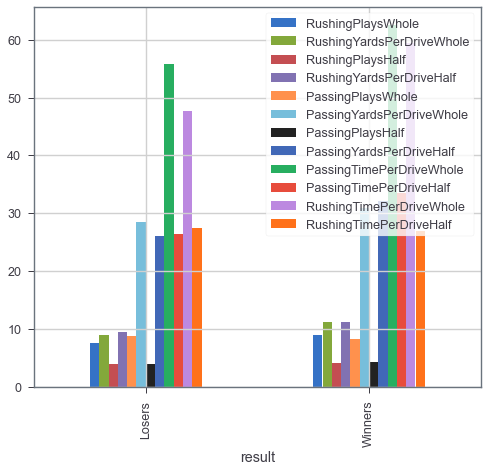

In [33]:
CombinedAveragesGroup = Combined.groupby("result").mean()
CombinedAveragesGroup = CombinedAveragesGroup.drop(["GameID", "lastDriveFirstHalf"], axis=1)
CombinedAveragesGroup.plot.bar()

Well, that's all the things we want but we'd rather x be each variable and the color be winners and losers. That would allow us to compare each variable between the winners and the losers more easily

<AxesSubplot:>

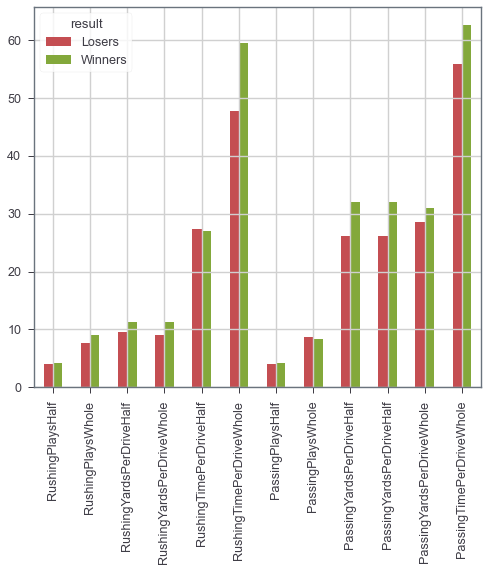

In [34]:
cols = [
    "RushingPlaysHalf", "RushingPlaysWhole", "RushingYardsPerDriveHalf", "RushingYardsPerDriveWhole",
    "RushingTimePerDriveHalf", "RushingTimePerDriveWhole",
    "PassingPlaysHalf", "PassingPlaysWhole", "PassingYardsPerDriveHalf", "PassingYardsPerDriveHalf",
    "PassingYardsPerDriveWhole", "PassingTimePerDriveWhole"
]

CombinedAveragesTransposed = CombinedAveragesGroup[cols].T
CombinedAveragesTransposed.plot.bar(color = ['r','g'])

<h1><a name="Conclusions"></a>Conclusions</h1>
A lot of these numbers are really similar. Clear outliers here are our passingTimePerDrive values, RushingTimePerDriveWhole value, and the PassingYardsPerDrive. It's interesting to note that the only statistic (other than number of plays) that the losing team beats the winning team in is RushingTimePerDriveHalf. This seems to indicate that winning teams on average want to get their run plays off quicker. Whether this is that their coaches playcall faster, or they settle on the line and snap more quickly, or something else entirely is impossible to tell from this.

Looking only at our Yardage statistics, the most noticeable different is between the PassingYardsPerDriveHalf where winning teams average 32 and losing teams only average 26. While this doesn't seem like a huge difference, when you consider that across all drives in the first half (generally about 6), thats a difference of about 30 yards in a half. That can be the difference in a scoring drive or not. So indication is that teams that have a more successful first half passing game are more likely to win. 

<h1><a name="Future"></a>Up next</h1>
There are several places where this work could be extended. One is to analyze the outliers in the data, which we can assume exist due to the high standard deviation in our average rushing and passing games. It would be interesting to analyze whether having a few huge plays has a high impact on a game, or if consistency is more important. 

Further, analysis of Special Teams and Defense would be interesting. Often it is assumed that teams that have large defensive plays, such as interceptions and fumble recoveries, are more likely to win. While this is likely true, an investigation into whether it has a measurable impact when analyzed across all games is worth while when many teams have to decide between drafting a defensive or offensive prospect. 

Finally, now that we have shown further evidence supporting Arkes's conclusion that the Passing squad has a larger impact that the Rushing squad, further analysis into target selection (which receiver and location to pass to) could yield interesting results. For example, are teams that have a powerful duo (e.g. Roethlisberger + Ward) more likely to win or is it important to have a large receiving core so that many options are available. Or perhaps it doesn't matter.